# West Coast Swing Playlist Analytics

Stemming from a one of the fantastic talks at [Westie Wisdom](https://www.super-secret-moves.com/workshops/fuer-trainer-und-organizer) where Flo G. detailed how he went about analyzing his sets using [Spotify's various metrics](https://developer.spotify.com/documentation/web-api/reference/get-audio-features) provided for songs. This is an attempt at continuing down that analytic path to answer some questions:

* **What do various WCS DJ playlists/sets look like?** (from the good to the bad - focusing mainly on the ordered playlists)
* **What music is (un)common in my bubble?** (get spotify connections and map their playlists)

## What do various WCS DJ playlists/sets look like?

### Tools
* Playlist analyzer: https://www.chosic.com/spotify-playlist-analyzer/
* BPM tool: https://www.all8.com/tools/bpm.htm
* Aleš' Event/DJ Playlist Tracker: http://klopca.com/dance/west-coast-swing/music/2024events

I pasted the spotify playlist links into the [playlist analyzer](https://www.chosic.com/spotify-playlist-analyzer/), and downloaded the `.csv` at the bottom

### Graphs! 
(😔 Have to use Matplotlib for Github viewing)

A beginner DJ made some playlists that were too fast (first 3 graphs), but you can see that on the 3rd, with guidance, the set improved around halfway through. Mistakes are great, because you get to improve, and it gives us examples to work with!

The subsequent graphs are sets during events from established DJ's, and you can see the slow pulses and/or gradual slowing of BPM.

`Note:`
*If you a really high or low spike that doesn't match the surrounding bpm's, it's likely because Spotify doesn't always get it right. I've tried to correct the worst ones, but there will still be some that escape.*

/opt/anaconda3/envs/py3.12/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


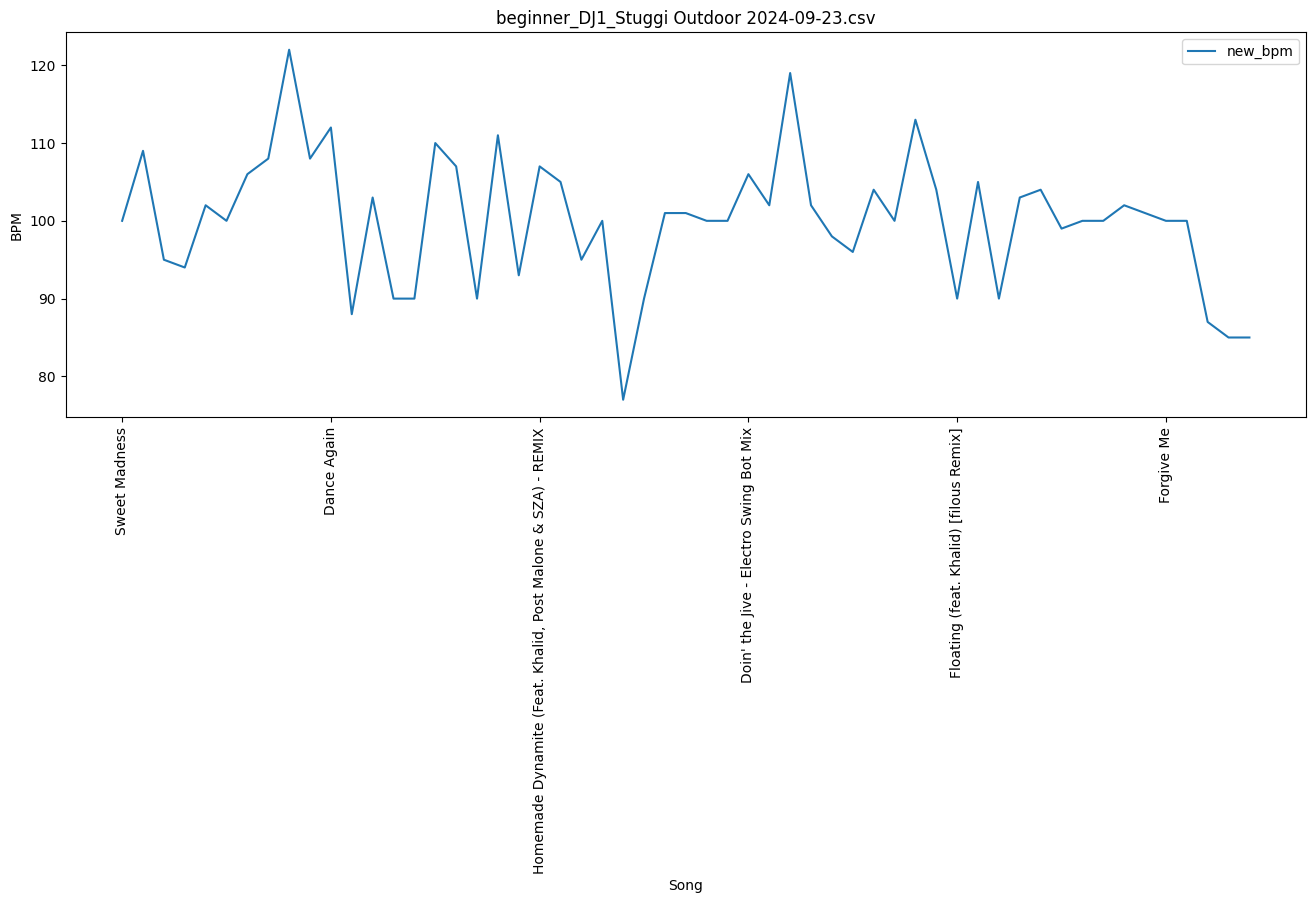

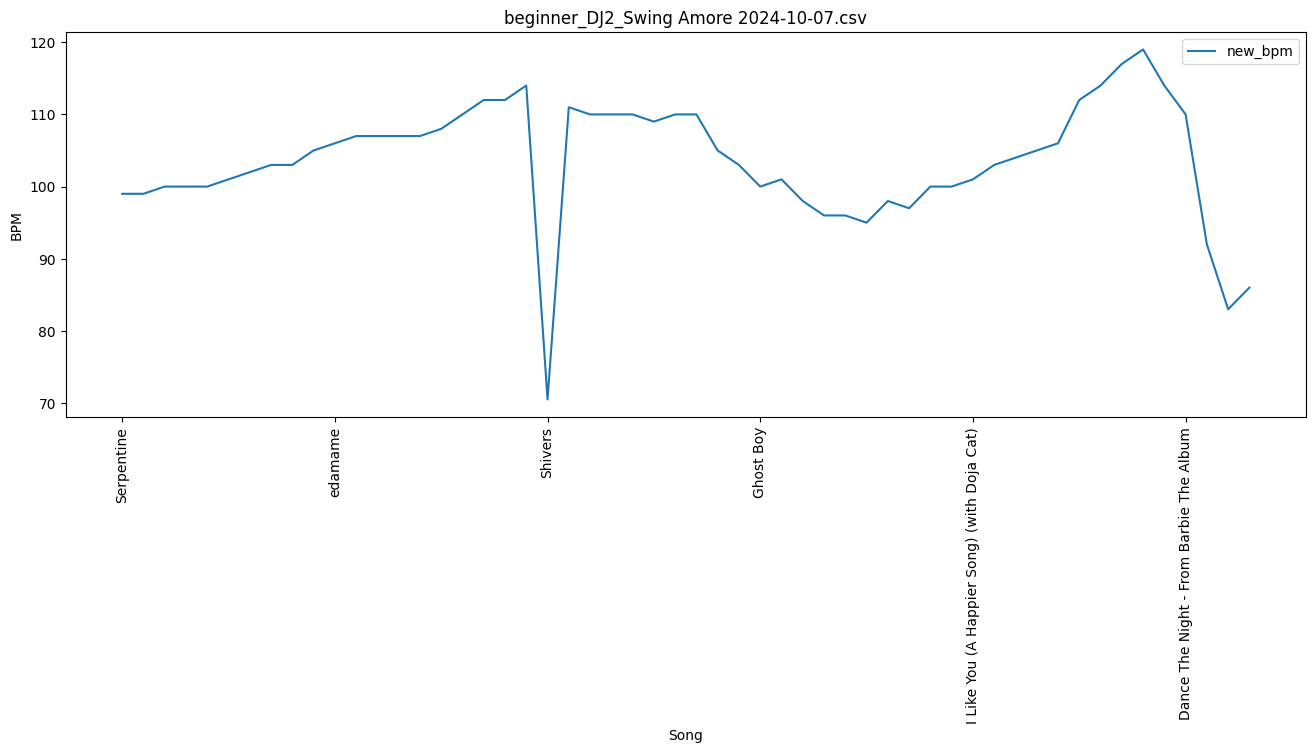

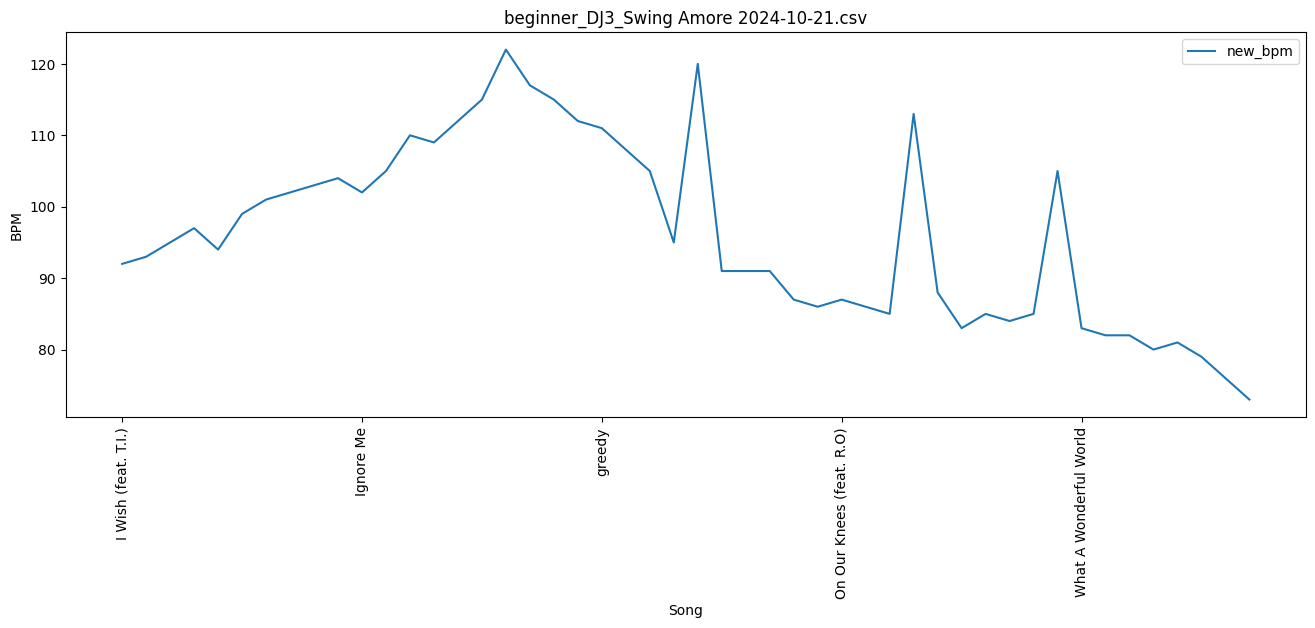

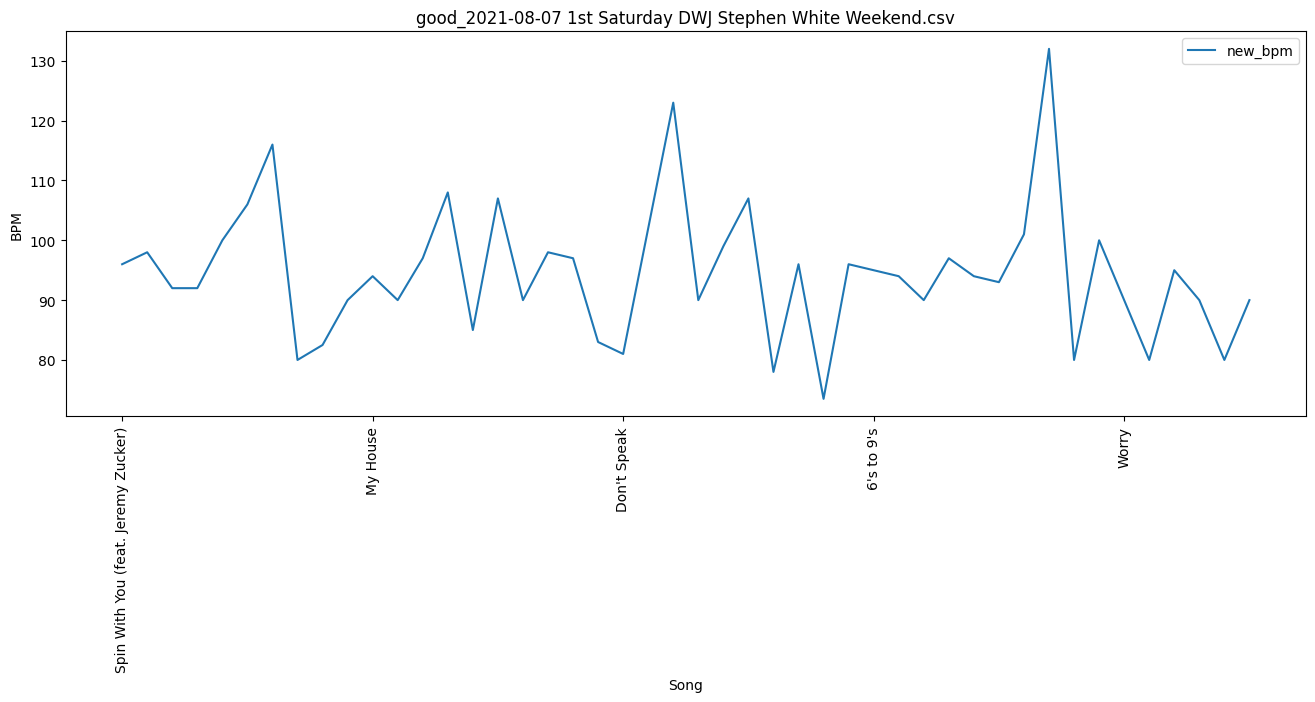

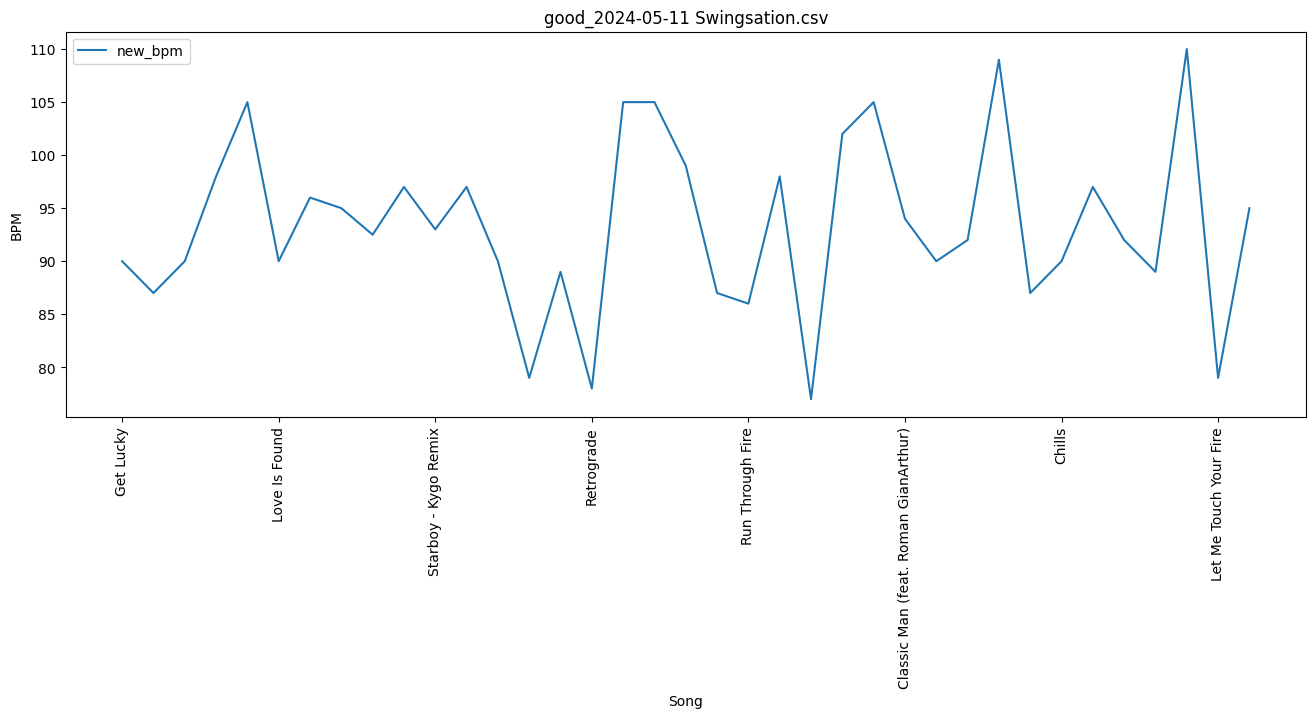

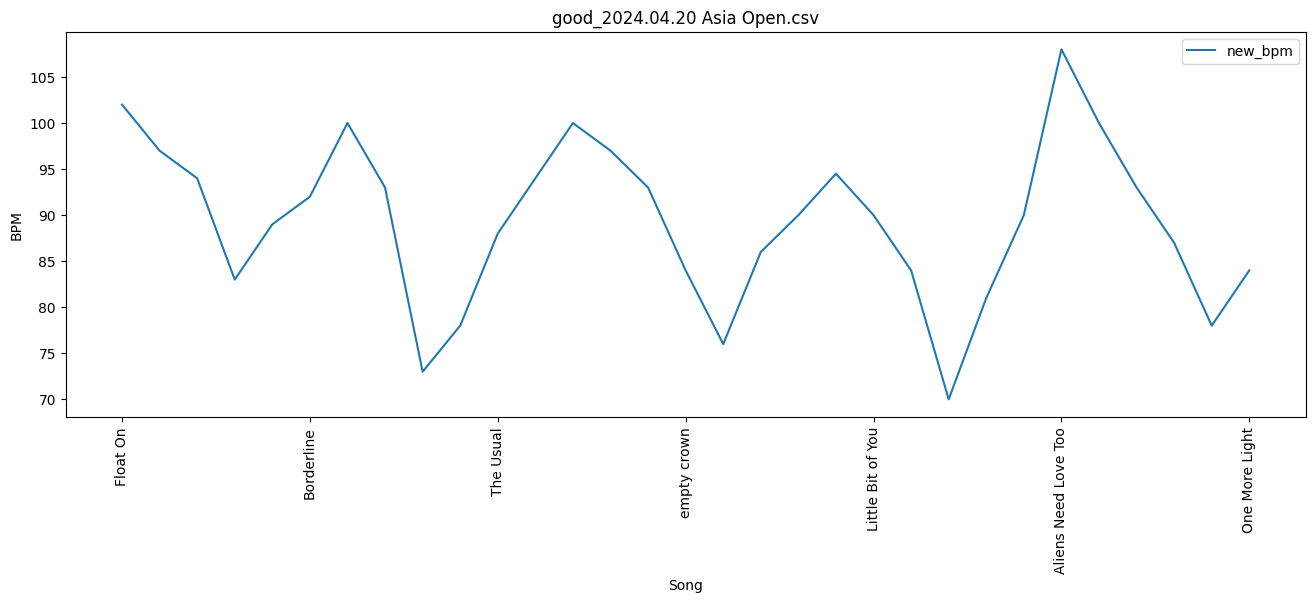

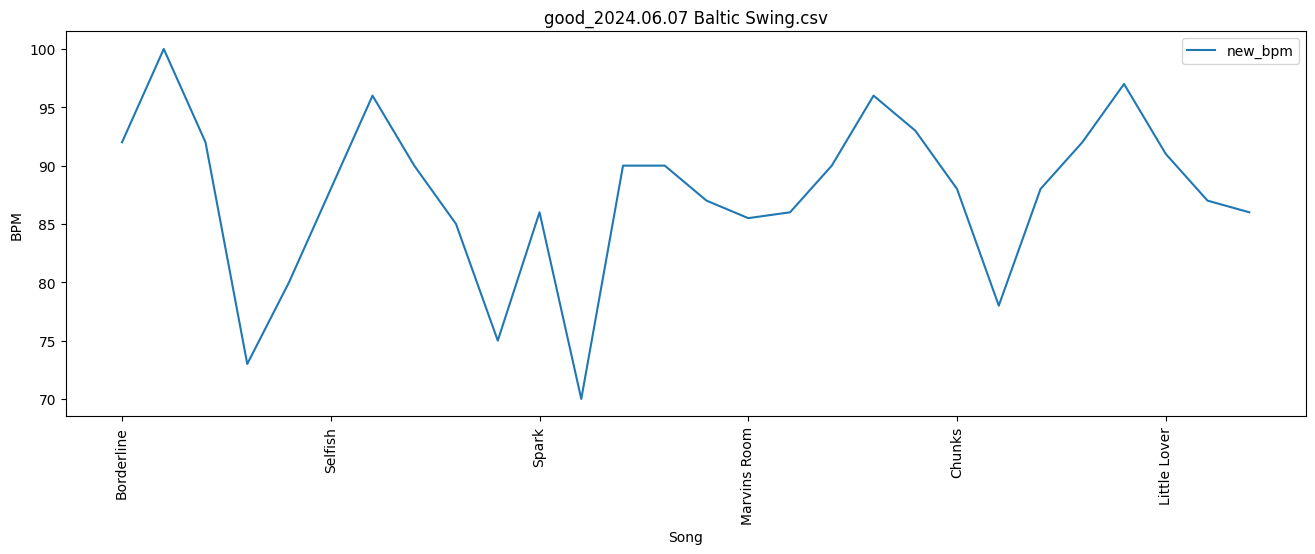

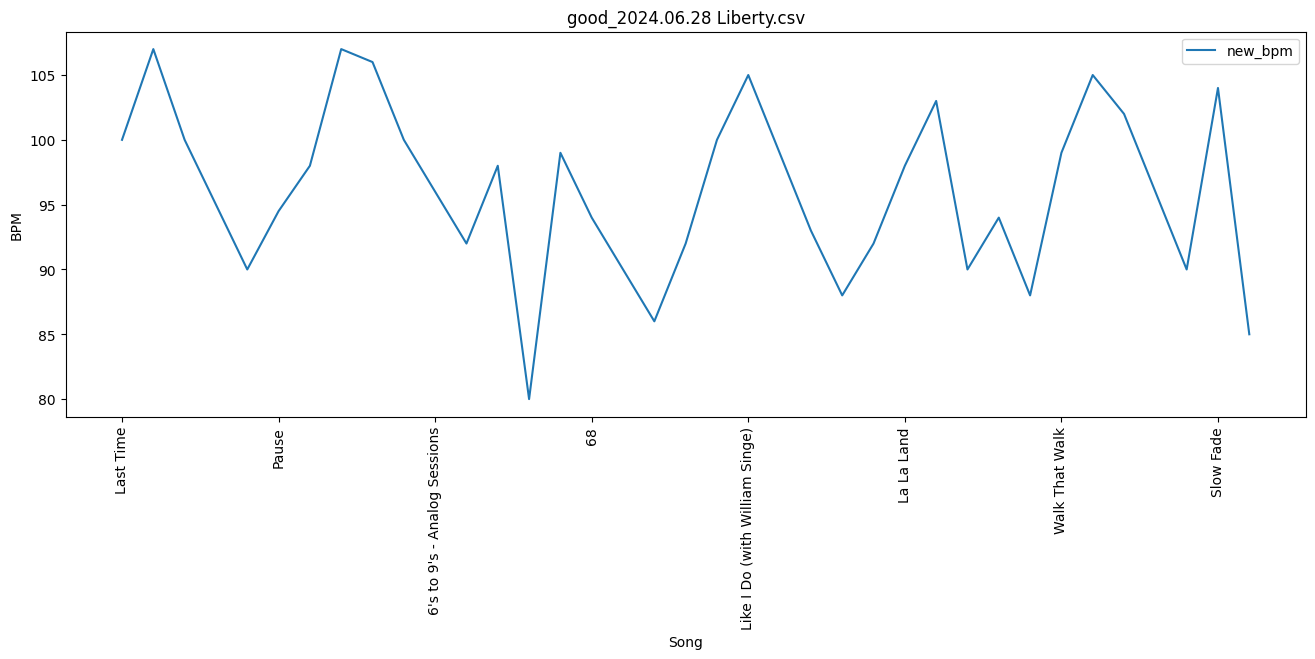

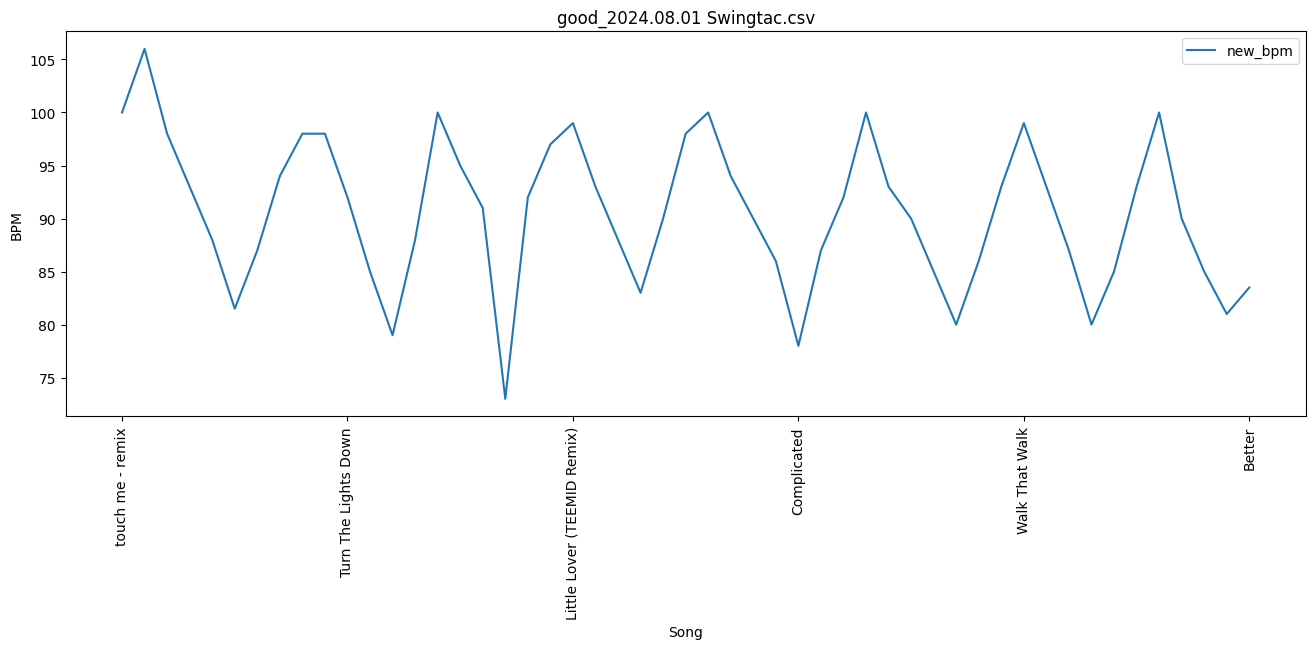

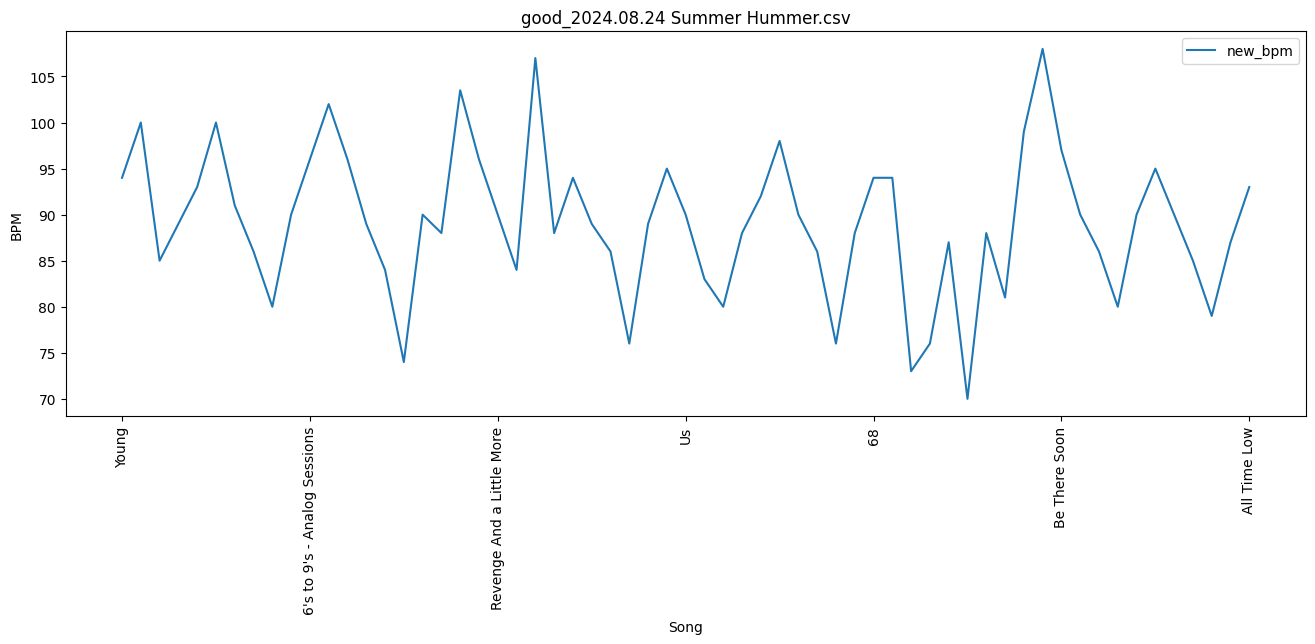

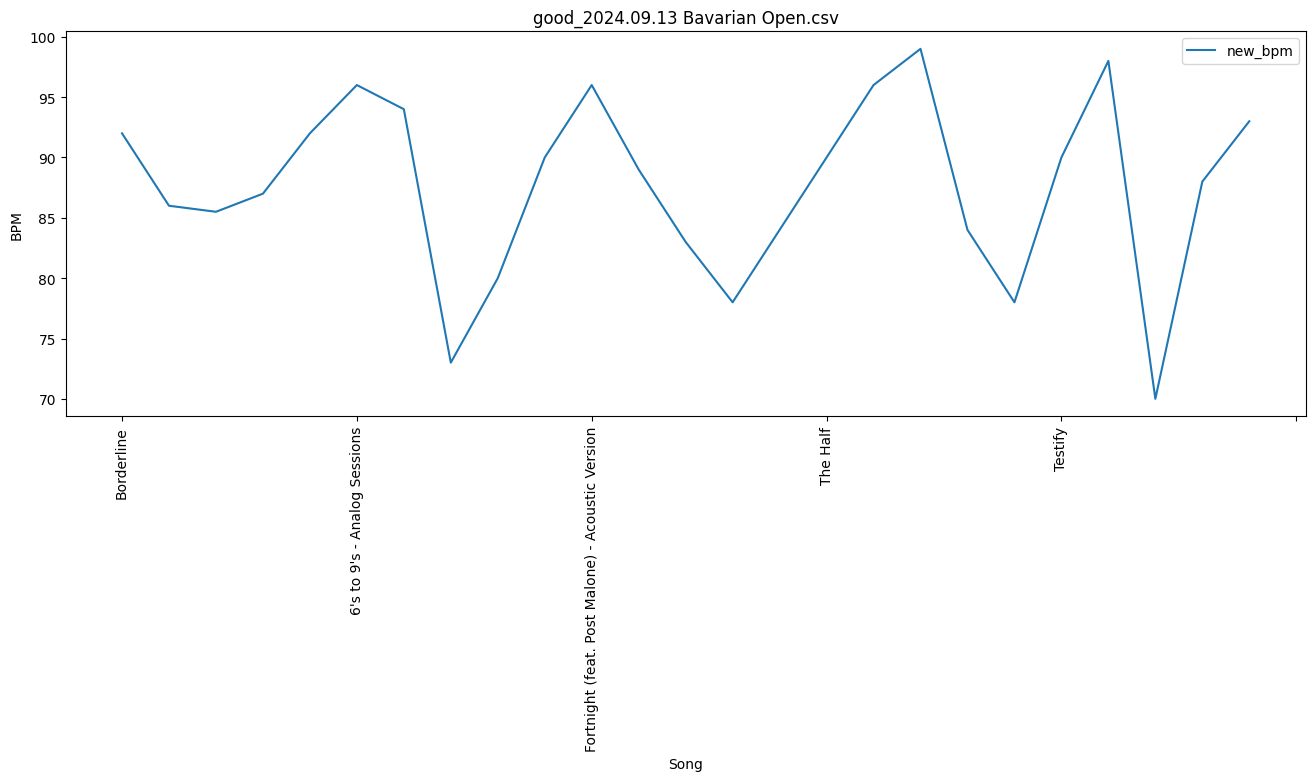

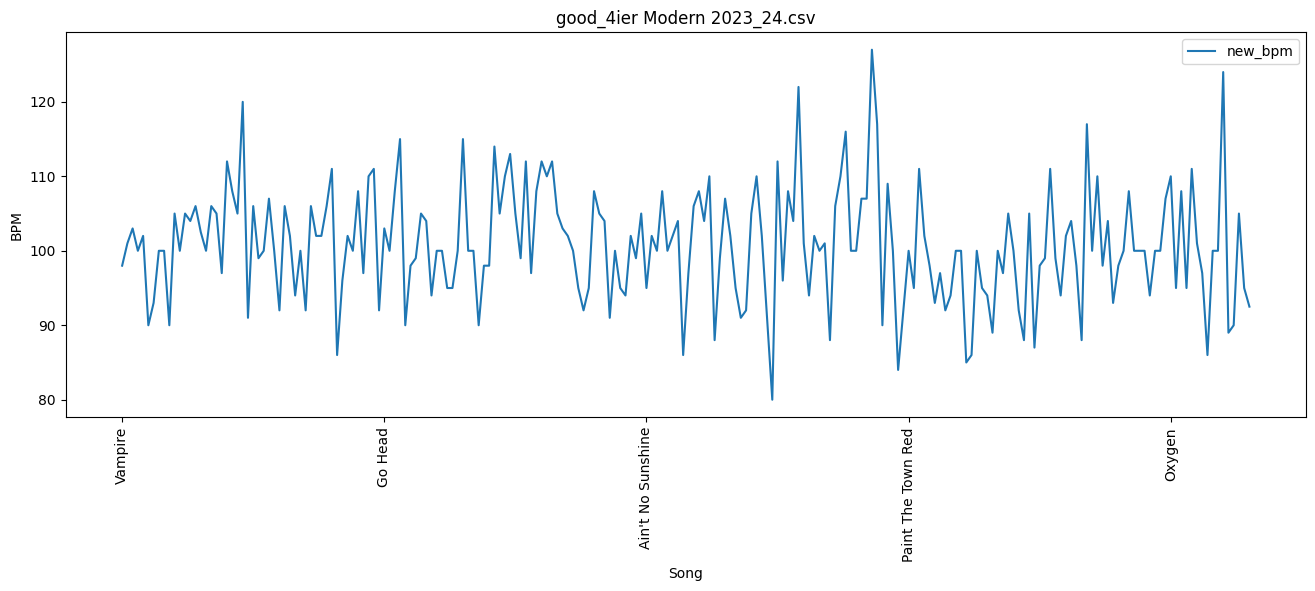

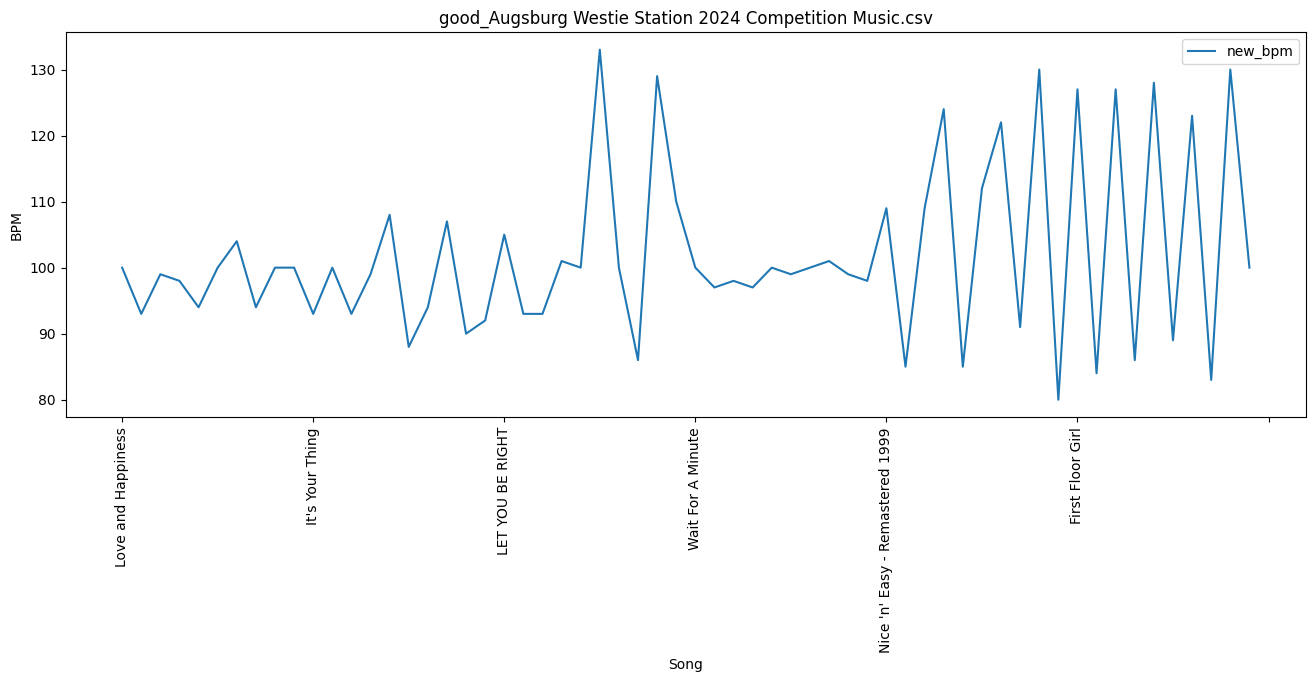

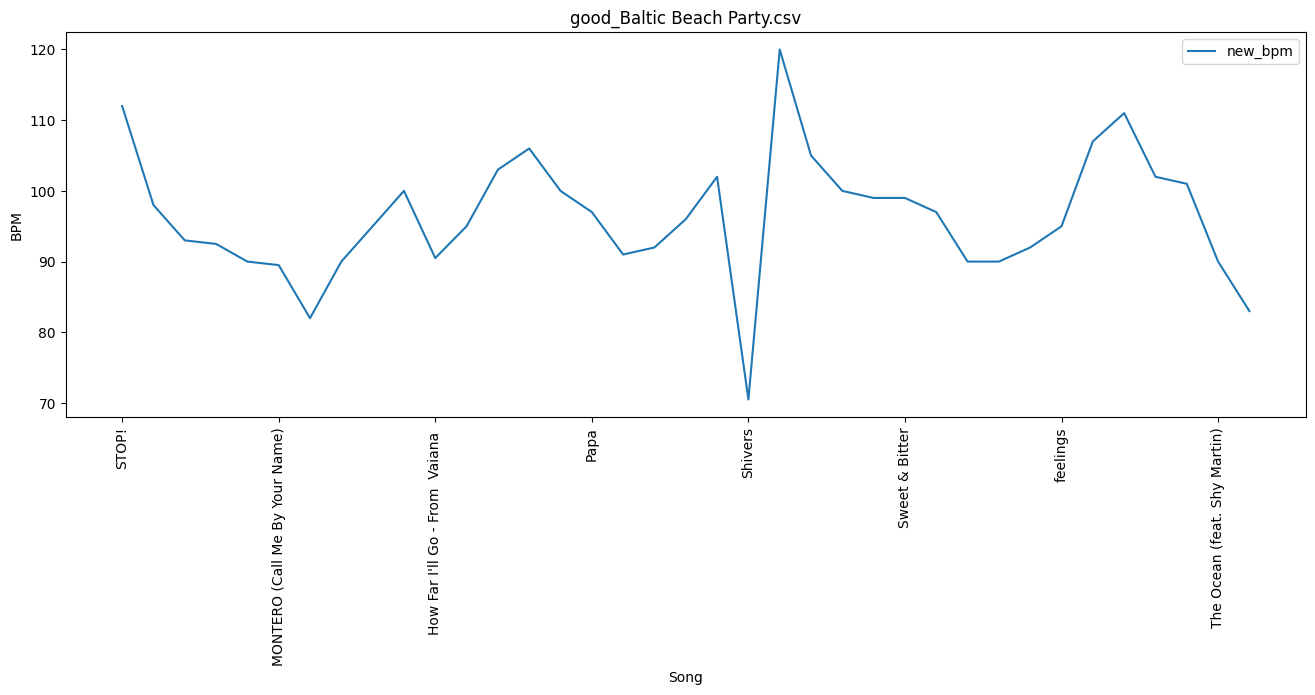

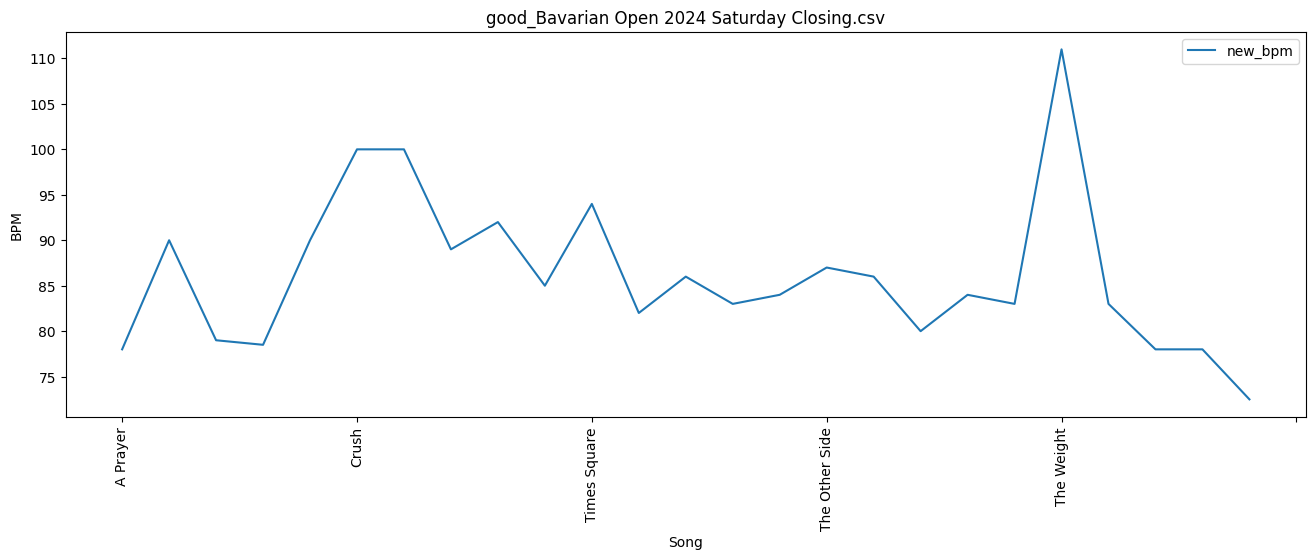

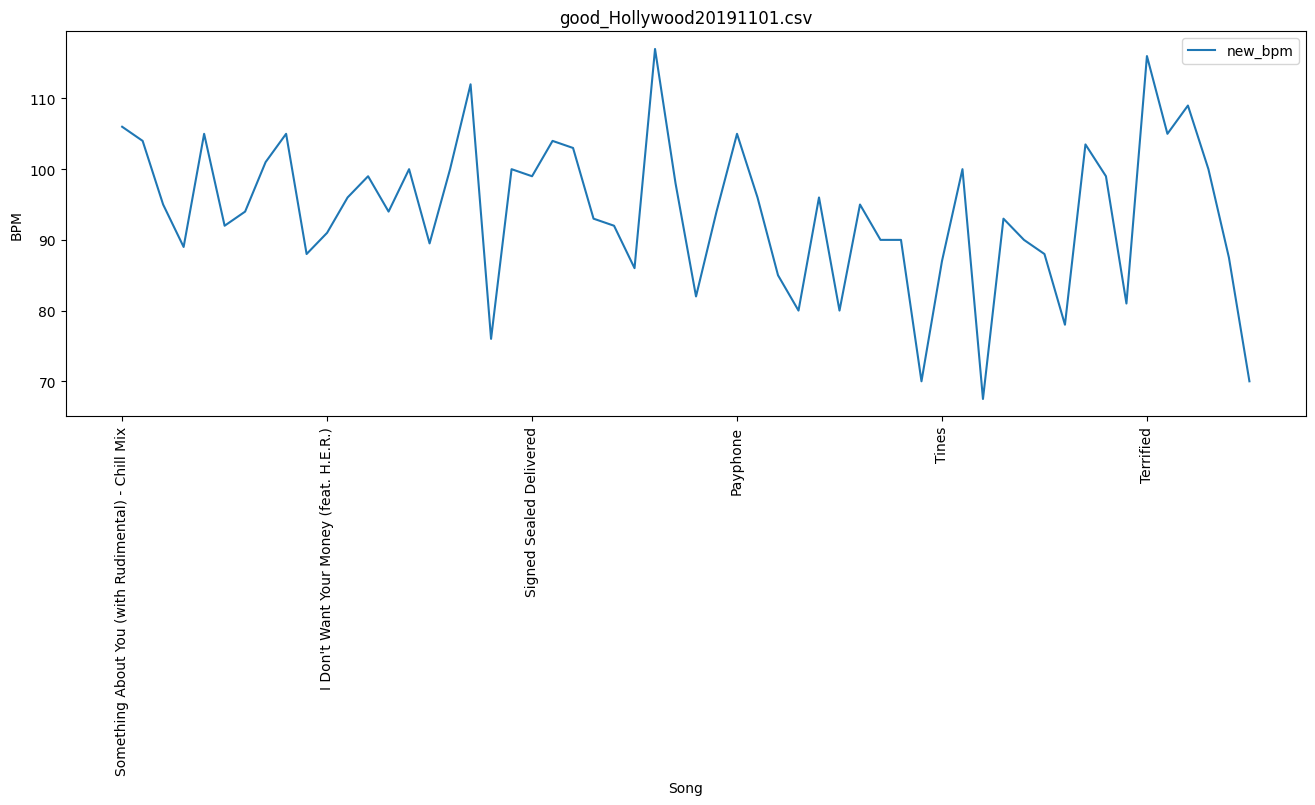

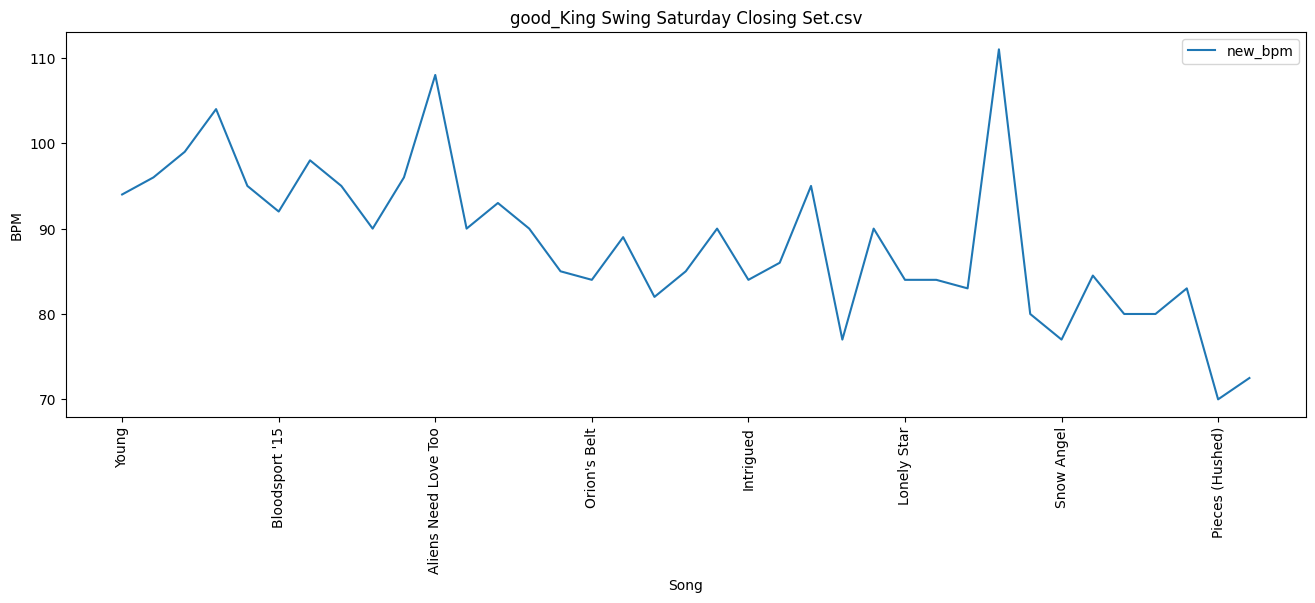

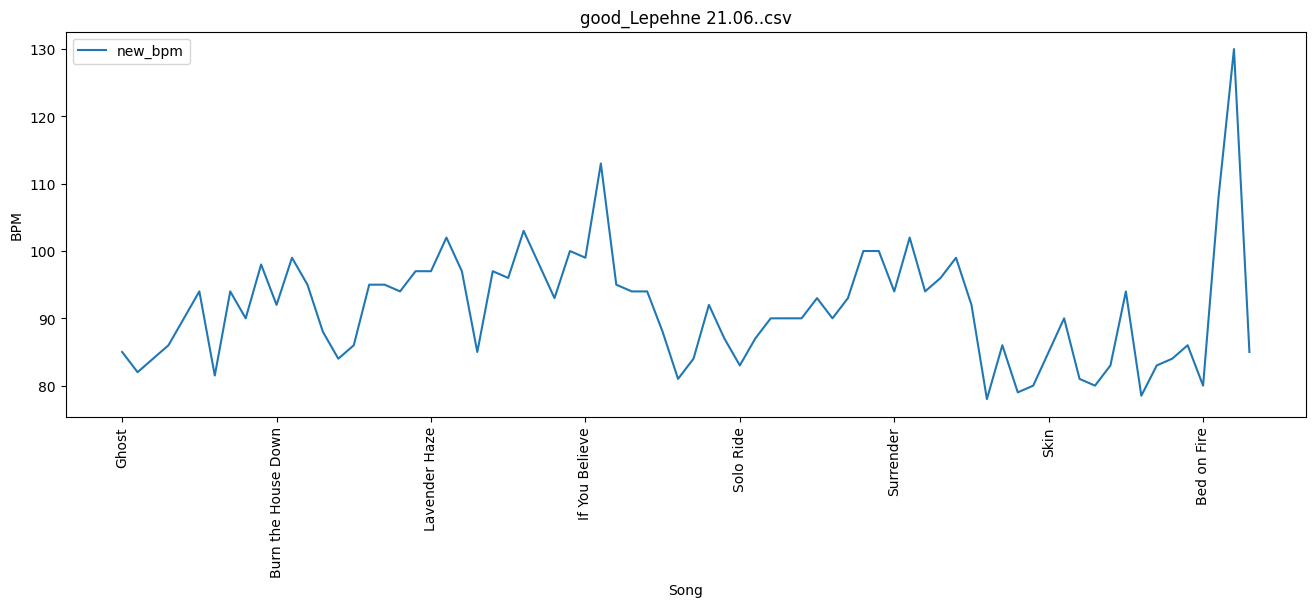

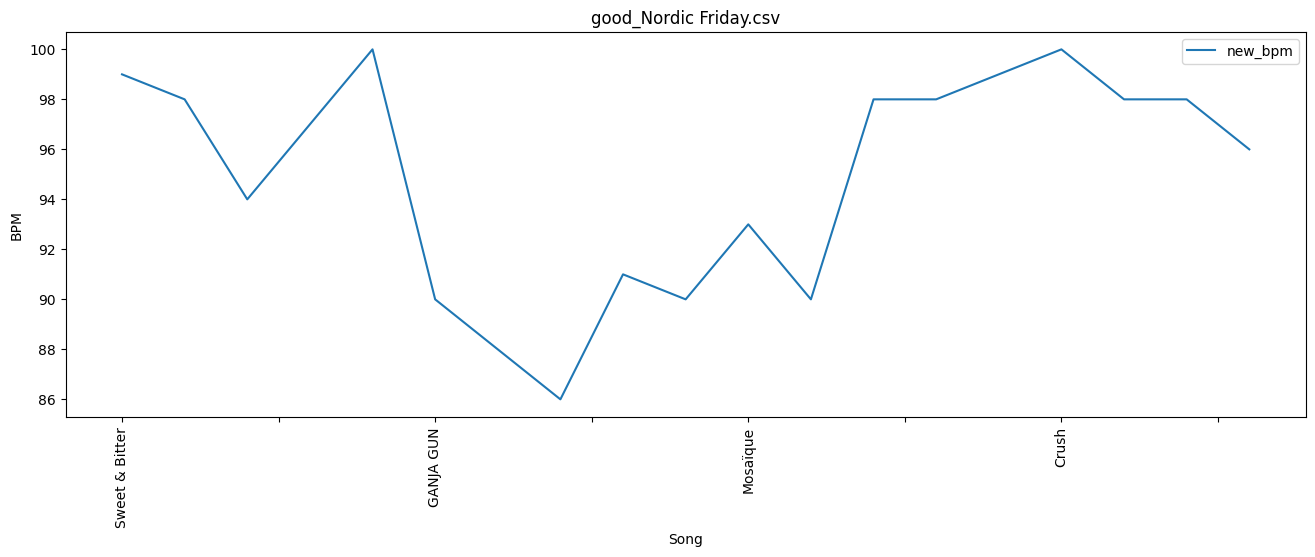

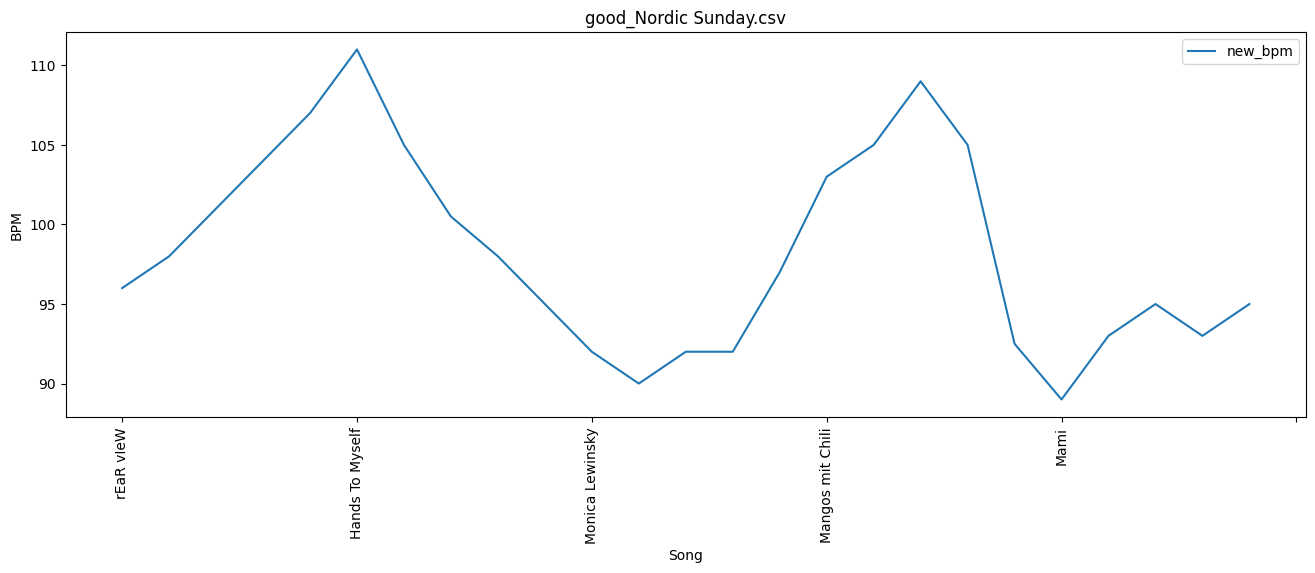

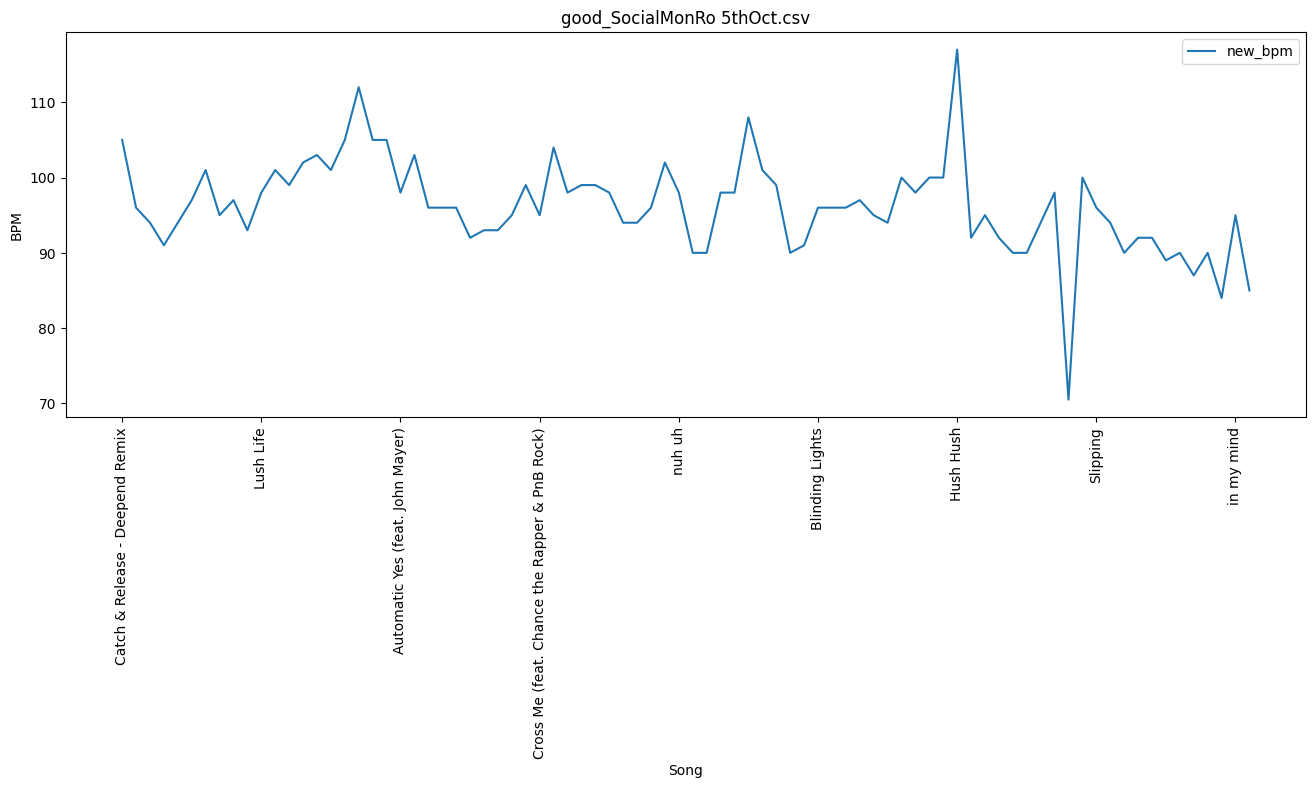

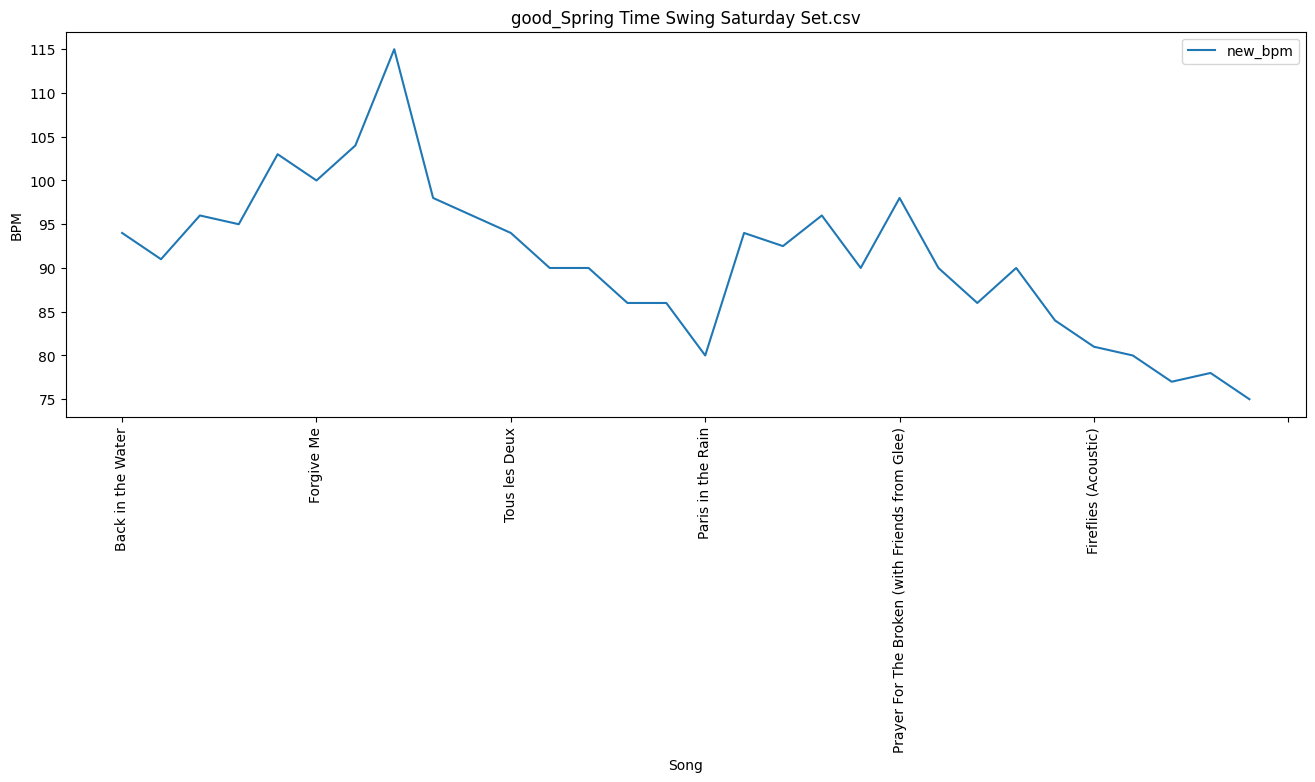

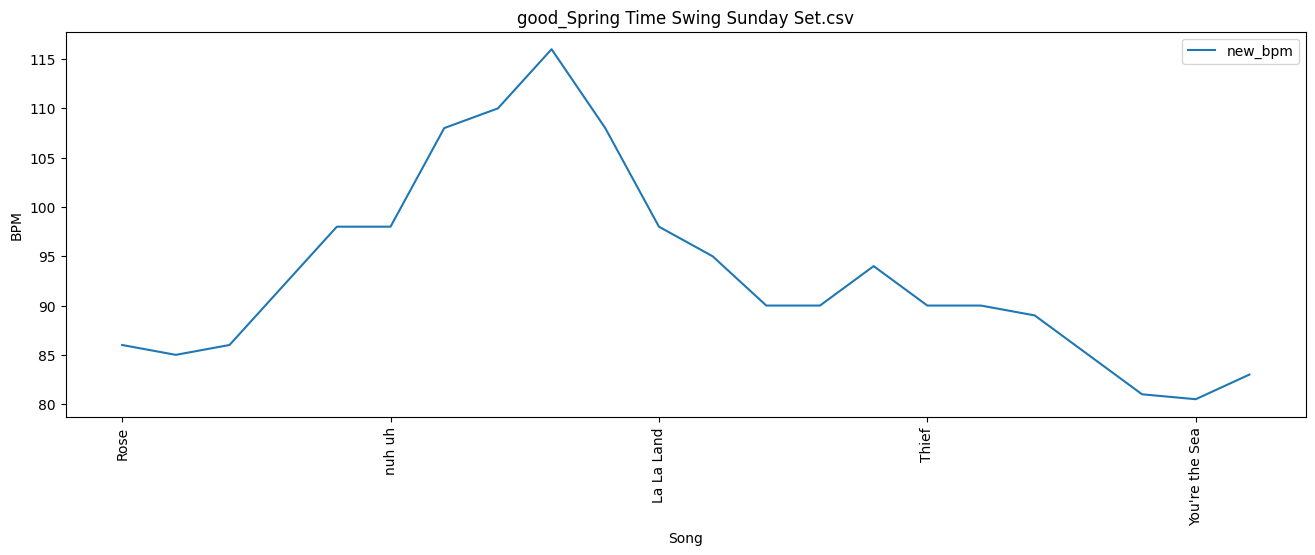

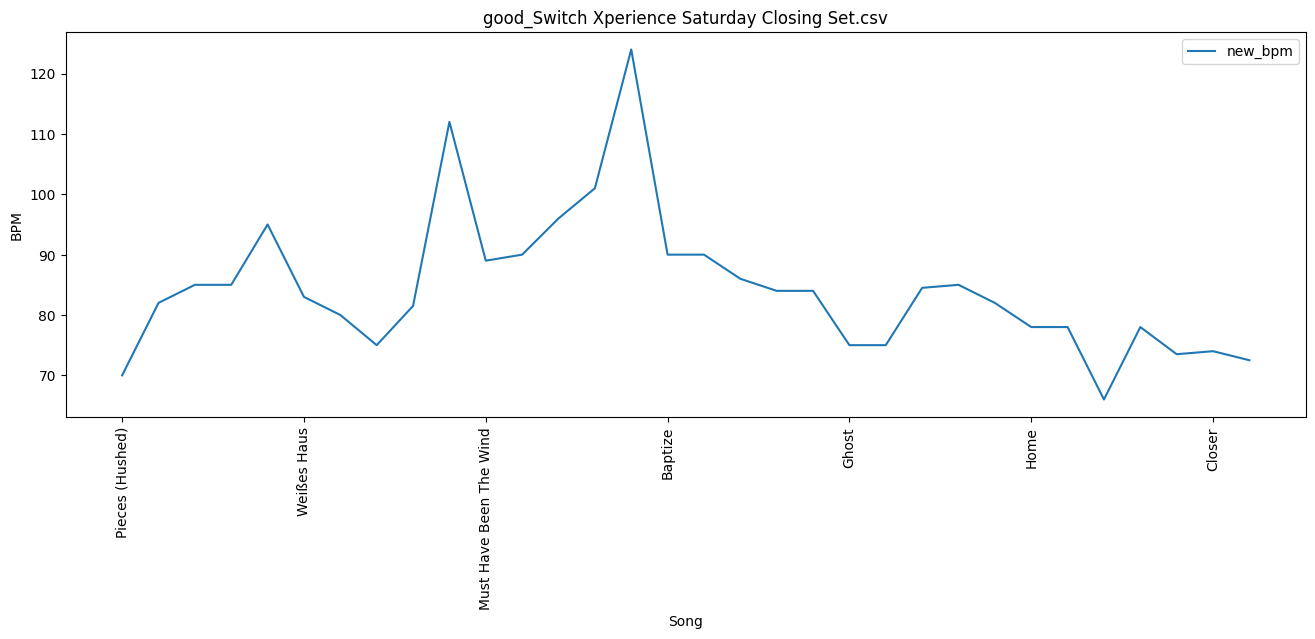

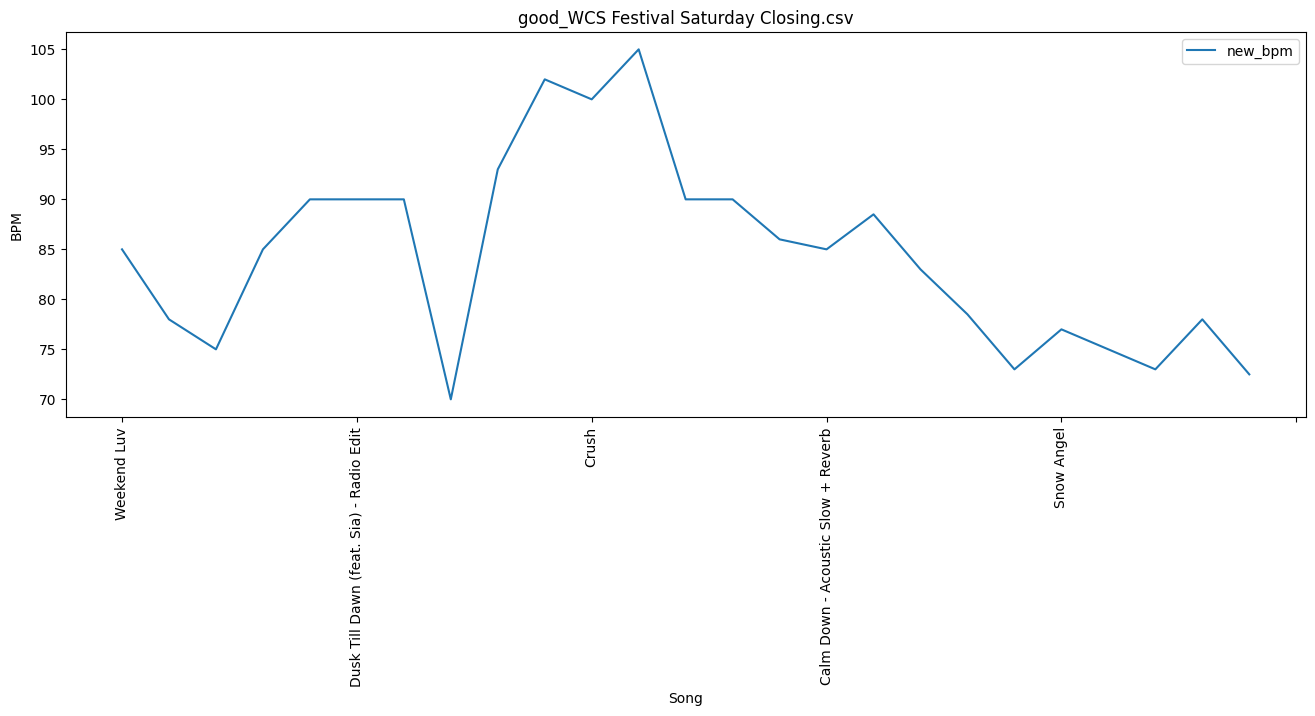

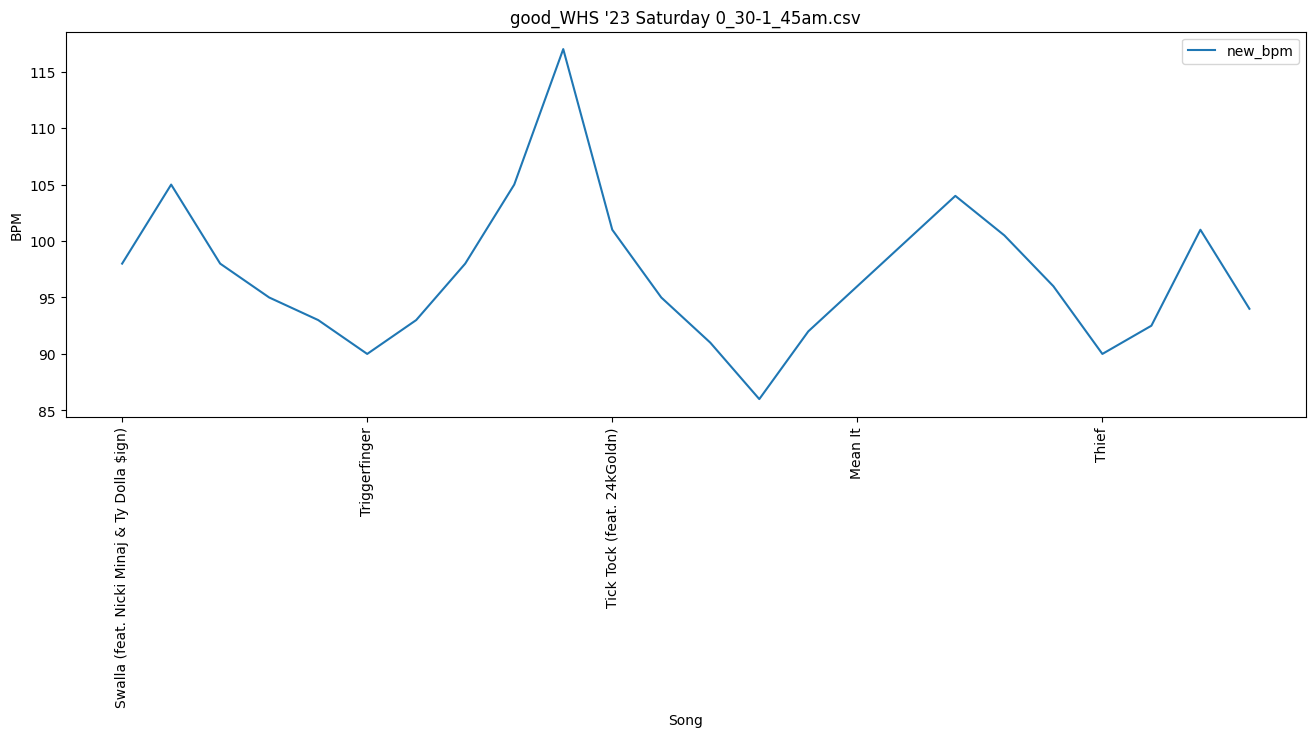

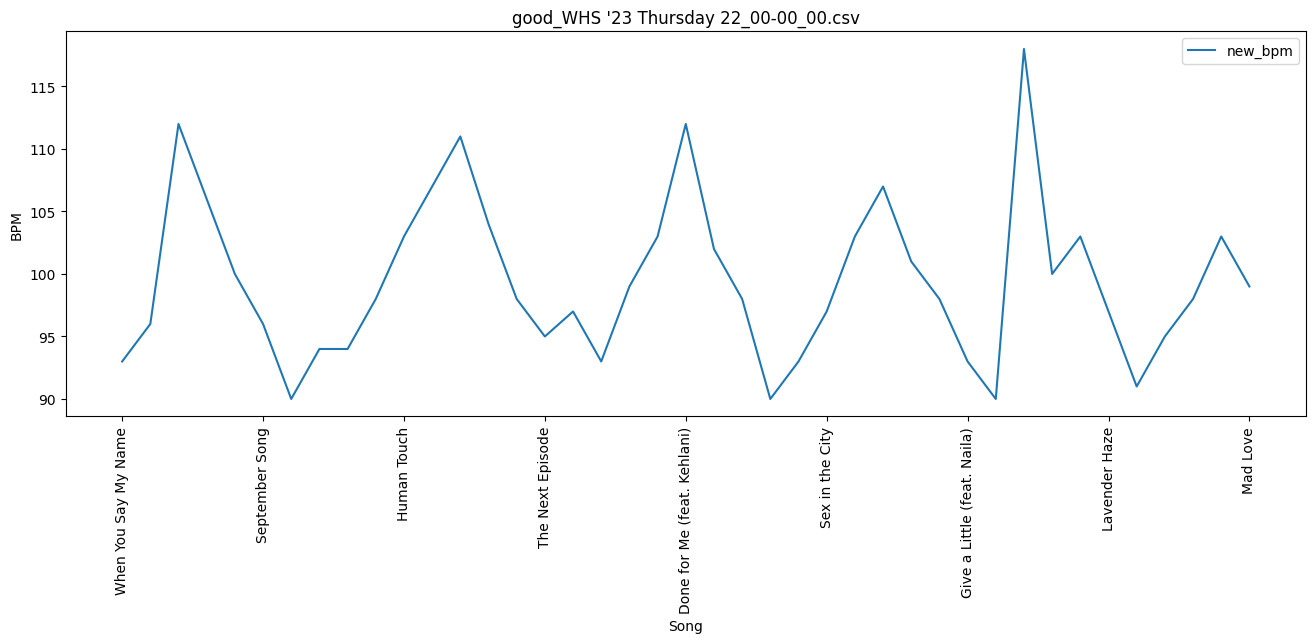

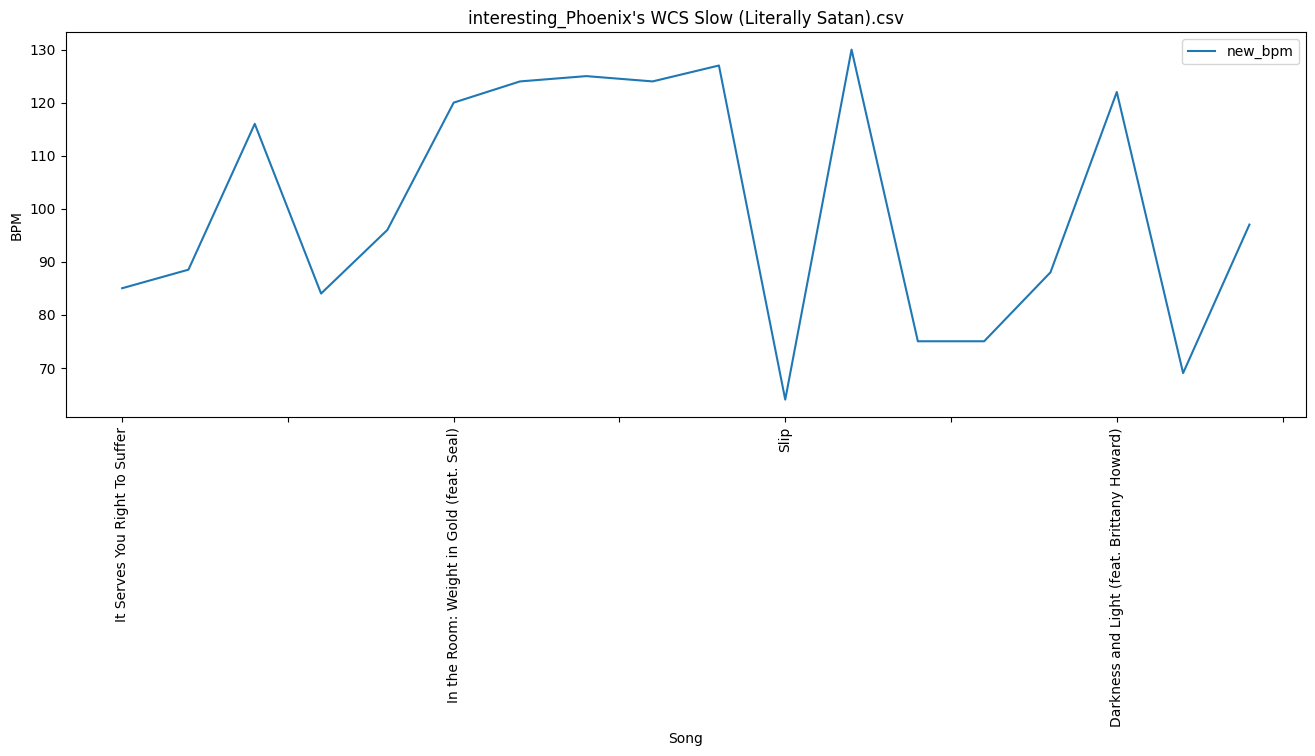

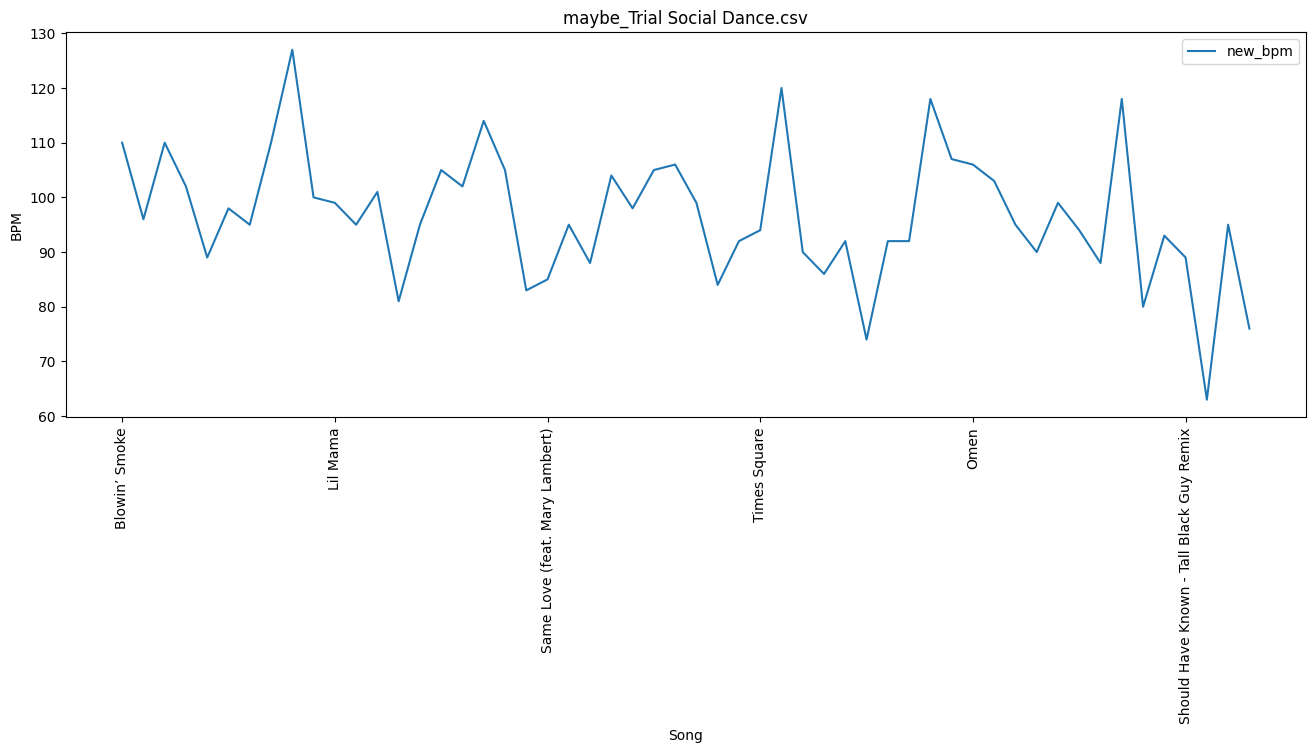

In [97]:
for i in sorted(os.listdir('Playlists/')):
    if 'unordered' not in i and '.csv' in i:
        (pl.read_csv(f'Playlists/{i}')
         .with_columns(
             #correctifies the worst of Spotify's bpm attempts
             new_bpm = pl.when(pl.col('BPM') >= 135)
                        .then(pl.col('BPM')/2)
                        .when(pl.col('BPM') <= 50)
                        .then(pl.col('BPM')*2)
                        .otherwise(pl.col('BPM')),
             #truncates loooong song names so they don't kill graph proportions
             song = pl.col('Song').str.slice(0,18),
         )
        .to_pandas()
        #plot things
        ).plot(x='Song', 
               y='new_bpm', 
               kind='line',
               title=i,
               figsize=(16, 5), 
               legend=True, 
               rot=90, 
               ylabel='BPM',
              )

### Observations

With Spotify's bpm inaccuracy, you can actually see how clear/simple the beats are in some of the sets. If there's a lot of variation or jumps, it likely means the songs have some complex rhythms that are confusing Spotify. Some playlists above show a clear `/\/\/\/\/\` which might be a good indicator that the beats are clear enough to dance to for beginners!



### Graphing with `hvplot`

In [ ]:
for i in sorted(os.listdir('Playlists/')):
    if 'unordered' not in i and '.csv' in i:
        display(pl.read_csv(f'Playlists/{i}').pipe(adjust_bpm)
                 
                #plot things
                .hvplot(x='song', 
                         y=['new_bpm',  
                            # 'Energy'
                           ], 
                         width=1300, 
                         height=500, 
                         stacked=True,
                         legend='top', 
                         title=i,
                        ).opts(xrotation=90)) #rotating song names

## Prepping the data for analysis

This is where we're gonna go from 0-100 real quick. I'm doing a lot of modifications - with comments - to prep our dataset for things we'll want to do later. This involves:
* Adding playlist names
* Correctify Spotify bpm blunders
* Truncate long song names
* Show where a song is in each playlist

In [88]:
# !pip install polars hvplot altair --upgrade
import polars as pl
import hvplot.polars
import os
import matplotlib as plt
import altair

dfs = []

for _ in sorted(os.listdir('Playlists/')):
    if '.csv' in _:
        df_ = pl.read_csv(f'Playlists/{_}')
        dfs.append(
            df_
             .pipe(adjust_bpm)
             .with_columns(
                 
                 #correctifies the worst of Spotify's bpm attempts
                 new_bpm = pl.when(pl.col('BPM') >= 135)
                            .then(pl.col('BPM')/2)
                            .when(pl.col('BPM') <= 50)
                            .then(pl.col('BPM')*2)
                            .otherwise(pl.col('BPM')),

                 #truncates loooong song names so they don't kill graph proportions
                 song = pl.col('Song').str.slice(0,18),

                 #set the playlist name
                 playlist = pl.lit(_),

                 #where the song is positioned in the playlist
                 song_position_in_playlist = pl.concat_str([pl.col('#'), pl.lit('/'), df_.shape[0]]),
                 
                 #where the song is positioned - beginning/middle/end
                 apprx_song_position_in_playlist = pl.when((pl.col('#')*100 / pl.lit(df_.shape[0])) <= 33)
                                                      .then(pl.lit('beginning'))
                                                      .when((pl.col('#')*100 / pl.lit(df_.shape[0])) >= 34,
                                                            (pl.col('#')*100 / pl.lit(df_.shape[0])) <= 66)
                                                      .then(pl.lit('middle'))
                                                      .when((pl.col('#')*100 / pl.lit(df_.shape[0])) >= 67)
                                                      .then(pl.lit('end'))
              )

             #prevents the numbers from being summed when they shouldn't be
             .select(pl.all().cast(pl.String))
            )

df = pl.concat(dfs)
df

#,Song,Artist,Popularity,BPM,Genres,Parent Genres,Album,Album Date,Time,Dance,Energy,Acoustic,Instrumental,Happy,Speech,Live,Loud (Db),Key,Time Signature,Added At,Spotify Track Id,Album Label,Camelot,ISRC,new_bpm,song,playlist,song_position_in_playlist,apprx_song_position_in_playlist
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""1""","""Sweet Madness""","""Sons Of Maria,Angelika Vee""","""6""","""100""","""deep tropical house, tropical …","""Electronic""","""Sweet Madness""","""2016-09-19""","""03:08""","""72""","""78""","""15""","""0""","""59""","""0""","""10""","""-3""","""G Minor""","""4""","""2024-09-20""","""6HYWlf6WdwxkTnBzpCTukU""","""Kontor Records""","""6A""","""DEN061600902""","""100.0""","""Sweet Madness""","""beginner_DJ1_Stuggi Outdoor 20…","""1/55""","""beginning"""
"""2""","""Not Going Home (feat. Gia Koka…","""DVBBS,CMC$,Gia Koka""","""46""","""109""","""canadian electronic, dutch hou…","""Electronic""","""Beautiful Disaster""","""2017-02-24""","""03:15""","""75""","""75""","""9""","""0""","""48""","""10""","""20""","""-6""","""F#/G♭ Major""","""4""","""2024-09-20""","""3JqjXikqS3jj8qWHs7OaLs""","""Ultra Records, LLC""","""2B""","""NLZ541601286""","""109.0""","""Not Going Home (fe""","""beginner_DJ1_Stuggi Outdoor 20…","""2/55""","""beginning"""
"""3""","""2step""","""Ed Sheeran,Lil Baby""","""6""","""95""","""pop, singer-songwriter pop, uk…","""Hip Hop, Pop""","""Guten Morgen - Coffee Hits""","""2022-09-23""","""02:43""","""69""","""64""","""14""","""0""","""48""","""0""","""10""","""-6""","""E Minor""","""4""","""2024-09-20""","""28vvDmRip7Rj1Z8xESXF5p""","""Warner Music Group - X5 Music …","""9A""","""GBAHS2200506""","""95.0""","""2step""","""beginner_DJ1_Stuggi Outdoor 20…","""3/55""","""beginning"""
"""4""","""AFU""","""CAL""","""30""","""94""","""""","""""","""The Identity Crisis: Side A""","""2019-11-15""","""03:07""","""83""","""78""","""16""","""1""","""89""","""0""","""0""","""-5""","""E Minor""","""4""","""2024-09-20""","""4SHxc1WUhxVKWgEa1kLvO8""","""Photo Finish Records""","""9A""","""GBKPL1973930""","""94.0""","""AFU""","""beginner_DJ1_Stuggi Outdoor 20…","""4/55""","""beginning"""
"""5""","""Je ne parle pas français""","""Namika""","""51""","""102""","""german pop""","""Pop""","""Que Walou""","""2018-06-01""","""03:00""","""77""","""52""","""13""","""0""","""79""","""0""","""50""","""-9""","""C Minor""","""4""","""2024-09-20""","""4eJqzRN15DabYK4byfWghD""","""Jive""","""5A""","""DEE861800295""","""102.0""","""Je ne parle pas fr""","""beginner_DJ1_Stuggi Outdoor 20…","""5/55""","""beginning"""
"""6""","""Ghost Boy""","""Jacob Tillberg""","""44""","""100""","""meme""","""Pop""","""Ghost Boy""","""2021-01-15""","""03:27""","""79""","""63""","""25""","""0""","""32""","""0""","""10""","""-7""","""E Minor""","""4""","""2024-09-20""","""6Sjl4KtCBxaJza3BTTXJE6""","""Discover Records""","""9A""","""TCAFI2166350""","""100.0""","""Ghost Boy""","""beginner_DJ1_Stuggi Outdoor 20…","""6/55""","""beginning"""
"""7""","""Like That (feat. Gucci Mane)""","""Doja Cat,Gucci Mane""","""70""","""106""","""dance pop, pop, atl hip hop, d…","""Hip Hop, Pop""","""Hot Pink""","""2019-11-07""","""02:43""","""88""","""50""","""24""","""0""","""41""","""10""","""10""","""-6""","""E Minor""","""4""","""2024-09-20""","""4EivmOT13NMpNSfTKn9p4s""","""Kemosabe Records/RCA Records""","""9A""","""USRC11902288""","""106.0""","""Like That (feat. G""","""beginner_DJ1_Stuggi Outdoor 20…","""7/55""","""beginning"""
"""8""","""Whatever""","""Kygo,Ava Max""","""78""","""108""","""edm, pop, pop dance, tropical …","""Electronic, Pop""","""Whatever""","""2024-01-19""","""02:58""","""58""","""78""","""10""","""0""","""59""","""0""","""30""","""-6""","""D#/E♭ Major""","""4""","""2024-09-20""","""0LMwmV37RCmBO2so0szAFs""","""Kygo/RCA Records""","""5B""","""USRC12302637""","""108.0""","""Whatever""","""beginner_DJ1_Stuggi Outdoor 20…","""8/55""","""beginning"""
"""9""","

## What music is (un)common in my bubble?

In [ ]:
#tbd

### What're the most and least common songs?

In [110]:
(df
 .group_by('Artist', 'Song')
 .agg(pl.col('#', 'song_position_in_playlist', 'apprx_song_position_in_playlist', 'playlist').sort())
 .with_columns(pl.col('playlist').list.unique().list.sort(),
               num_playlists = pl.col('playlist').list.unique().list.len())
 .sort('num_playlists', descending = True)
)

Artist,Song,#,song_position_in_playlist,apprx_song_position_in_playlist,playlist,num_playlists
str,str,list[str],list[str],list[str],list[str],u32
"""Oh Wonder""","""Lonely Star""","[""140"", ""15"", ""15"", ""15"", ""22"", ""25"", ""26""]","[""140/149"", ""15/25"", ""15/25"", ""15/61"", ""22/31"", ""25/30"", ""26/37""]","[""beginning"", ""end"", ""end"", ""end"", ""end"", ""middle"", ""middle""]","[""good_2024.04.20 Asia Open.csv"", ""good_2024.08.24 Summer Hummer.csv"", ""good_2024.09.13 Bavarian Open.csv"", ""good_Bavarian Open 2024 Saturday Closing.csv"", ""good_King Swing Saturday Closing Set.csv"", ""good_Spring Time Swing Saturday Set.csv"", ""unordered_WCcoolStuff..csv""]",7
"""SYML""","""Fear of the Water""","[""13"", ""141"", ""25"", ""28"", ""46"", ""7"", ""9""]","[""13/37"", ""141/149"", ""25/25"", ""28/31"", ""46/51"", ""7/42"", ""9/25""]","[""beginning"", ""end"", ""end"", ""end"", ""end"", ""middle"", ""middle""]","[""good_2024.04.20 Asia Open.csv"", ""good_2024.08.01 Swingtac.csv"", ""good_2024.09.13 Bavarian Open.csv"", ""good_King Swing Saturday Closing Set.csv"", ""good_WCS Festival Saturday Closing.csv"", ""unordered_DJ Workshop.csv"", ""unordered_WCcoolStuff..csv""]",7
"""Neon Dreams""","""Times Square""","[""11"", ""17"", ""29"", ""3"", ""31"", ""42"", ""7""]","[""11/25"", ""17/30"", ""29/37"", ""3/31"", ""31/54"", ""42/61"", ""7/25""]","[""beginning"", ""beginning"", ""end"", ""end"", ""middle"", ""middle"", ""middle""]","[""good_2024.04.20 Asia Open.csv"", ""good_2024.06.28 Liberty.csv"", ""good_2024.08.24 Summer Hummer.csv"", ""good_2024.09.13 Bavarian Open.csv"", ""good_Bavarian Open 2024 Saturday Closing.csv"", ""good_Spring Time Swing Saturday Set.csv"", ""maybe_Trial Social Dance.csv""]",7
"""Nick Broadhurst""","""Little Lover""","[""12"", ""13"", ""22"", ""25"", ""26"", ""37"", ""5""]","[""12/32"", ""13/25"", ""22/30"", ""25/42"", ""26/28"", ""37/61"", ""5/25""]","[""beginning"", ""end"", ""end"", ""middle"", ""middle"", ""middle"", ""middle""]","[""good_2024.06.07 Baltic Swing.csv"", ""good_2024.08.24 Summer Hummer.csv"", ""good_Bavarian Open 2024 Saturday Closing.csv"", ""good_Spring Time Swing Saturday Set.csv"", ""good_Switch Xperience Saturday Closing Set.csv"", ""good_WCS Festival Saturday Closing.csv"", ""unordered_DJ Workshop.csv""]",7
"""Emeli Sandé""","""Oxygen""","[""136"", ""15"", ""17"", ""18"", ""35"", ""54"", ""70""]","[""136/149"", ""15/30"", ""17/25"", ""18/32"", ""35/42"", ""54/54"", ""70/74""]","[""end"", ""end"", ""end"", ""end"", ""end"", ""middle"", ""middle""]","[""beginner_DJ2_Swing Amore 2024-10-07.csv"", ""good_Bavarian Open 2024 Saturday Closing.csv"", ""good_Lepehne 21.06..csv"", ""good_Spring Time Swing Saturday Set.csv"", ""good_Switch Xperience Saturday Closing Set.csv"", ""unordered_DJ Workshop.csv"", ""unordered_WCcoolStuff..csv""]",7
"""Jades Goudreault""","""nuh uh""","[""2"", ""39"", ""41"", ""41"", ""6"", ""7"", ""9""]","[""2/37"", ""39/41"", ""41/42"", ""41/82"", ""6/22"", ""7/37"", ""9/51""]","[""beginning"", ""beginning"", ""beginning"", ""beginning"", ""end"", ""end"", ""middle""]","[""good_2024.06.28 Liberty.csv"", ""good_2024.08.01 Swingtac.csv"", ""good_Baltic Beach Party.csv"", ""good_SocialMonRo 5thOct.csv"", ""good_Spring Time Swing Sunday Set.csv"", ""good_WHS '23 Thursday 22_00-00_00.csv"", ""unordered_DJ Workshop.csv""]",7
"""Ruben""","""The Half""","[""16"", ""17"", ""17"", ""19"", ""25"", ""35""]","[""16/25"", ""17/22"", ""17/61"", ""19/31"", ""25/51"", ""35/37""]","[""beginning"", ""end"", ""end"", ""middle"", ""middle"", ""middle""]","[""good_2024.04.20 Asia Open.csv"", ""good_2024.06.28 Liberty.csv"", ""good_2024.08.01 Swingtac.csv"", ""good_2024.08.24 Summer Hummer.csv"", ""good_2024.09.13 Bavarian Open.csv"", ""good_Spring Time Swing Sunday Set.csv""]",6
"""Phlake,Mercedes the Virus""","""Aliens Need Love Too""","[""11"", ""193"", ""26"", ""50"", ""51"", ""72""]","[""11/37"", ""193/216"", ""26/31"", ""50/61"", ""51/149"", ""72/74""]","[""beg

### Which Artists are most played among everyone?

In [111]:
pl.Config.set_fmt_table_cell_list_len(15)

(df
 .group_by('Artist')
 .agg(pl.col('#', 'song_position_in_playlist', 'apprx_song_position_in_playlist', 'playlist').sort())
 .with_columns(pl.col('playlist').list.unique().list.sort(),
               num_playlists = pl.col('playlist').list.unique().list.len())
 .sort('num_playlists', descending = True)
)

Artist,#,song_position_in_playlist,apprx_song_position_in_playlist,playlist,num_playlists
str,list[str],list[str],list[str],list[str],u32
"""Ed Sheeran""","[""11"", ""12"", ""13"", ""142"", ""15"", ""18"", ""21"", ""21"", ""30"", ""44"", ""48"", ""5"", ""69"", ""8""]","[""11/28"", ""12/24"", ""13/74"", ""142/216"", ""15/25"", ""18/42"", ""21/37"", ""21/54"", ""30/51"", ""44/61"", ""48/216"", ""5/12"", ""69/82"", ""8/12""]","[null, ""beginning"", ""beginning"", ""end"", ""end"", ""middle"", ""middle"", ""middle"", ""middle"", ""middle"", ""middle"", ""middle"", ""middle"", ""middle""]","[""beginner_DJ2_Swing Amore 2024-10-07.csv"", ""good_2024.06.07 Baltic Swing.csv"", ""good_2024.08.01 Swingtac.csv"", ""good_2024.08.24 Summer Hummer.csv"", ""good_4ier Modern 2023_24.csv"", ""good_Baltic Beach Party.csv"", ""good_Lepehne 21.06..csv"", ""good_SocialMonRo 5thOct.csv"", ""good_WCS Festival Saturday Closing.csv"", ""good_WHS '23 Saturday 0_30-1_45am.csv"", ""unordered_DJ Workshop.csv"", ""unordered_WCS Gentle.csv""]",12
"""HAEVN""","[""1"", ""10"", ""14"", ""15"", ""17"", ""20"", ""27"", ""5"", ""66"", ""68"", ""8""]","[""1/30"", ""10/115"", ""14/56"", ""15/31"", ""17/19"", ""20/28"", ""27/51"", ""5/61"", ""66/74"", ""68/82"", ""8/42""]","[""beginning"", ""beginning"", ""beginning"", ""beginning"", ""beginning"", ""end"", ""end"", ""end"", ""end"", ""middle"", ""middle""]","[""good_2024.04.20 Asia Open.csv"", ""good_2024.06.07 Baltic Swing.csv"", ""good_2024.08.01 Swingtac.csv"", ""good_2024.08.24 Summer Hummer.csv"", ""good_Hollywood20191101.csv"", ""good_Lepehne 21.06..csv"", ""good_Nordic Friday.csv"", ""good_SocialMonRo 5thOct.csv"", ""good_Spring Time Swing Saturday Set.csv"", ""unordered_DJ Workshop.csv"", ""unordered_Shazamibles.csv""]",11
"""SYML""","[""13"", ""13"", ""141"", ""18"", ""25"", ""28"", ""28"", ""46"", ""51"", ""7"", ""9""]","[""13/32"", ""13/37"", ""141/149"", ""18/18"", ""25/25"", ""28/31"", ""28/61"", ""46/51"", ""51/51"", ""7/42"", ""9/25""]","[""beginning"", ""end"", ""end"", ""end"", ""end"", ""end"", ""end"", ""middle"", ""middle"", ""middle"", ""middle""]","[""good_2024.04.20 Asia Open.csv"", ""good_2024.08.01 Swingtac.csv"", ""good_2024.08.24 Summer Hummer.csv"", ""good_2024.09.13 Bavarian Open.csv"", ""good_King Swing Saturday Closing Set.csv"", ""good_Switch Xperience Saturday Closing Set.csv"", ""good_WCS Festival Saturday Closing.csv"", ""interesting_Phoenix's WCS Slow (Literally Satan).csv"", ""unordered_DJ Workshop.csv"", ""unordered_WCcoolStuff..csv""]",10
"""Billie Eilish""","[""102"", ""13"", ""15"", ""15"", ""17"", ""17"", ""174"", ""22"", ""32"", ""32"", ""34"", ""5"", ""59""]","[""102/149"", ""13/70"", ""15/115"", ""15/70"", ""17/24"", ""17/56"", ""174/216"", ""22/24"", ""32/46"", ""32/54"", ""34/74"", ""5/70"", ""59/61""]","[""beginning"", ""beginning"", ""beginning"", ""beginning"", ""beginning"", ""end"", ""end"", ""end"", ""end"", ""end"", ""end"", ""middle"", ""middle""]","[""good_2021-08-07 1st Saturday DWJ Stephen White Weekend.csv"", ""good_2024.08.24 Summer Hummer.csv"", ""good_4ier Modern 2023_24.csv"", ""good_Hollywood20191101.csv"", ""good_Lepehne 21.06..csv"", ""good_WHS '23 Saturday 0_30-1_45am.csv"", ""maybe_Trial Social Dance.csv"", ""unordered_Shazamibles.csv"", ""unordered_WCS Halloween Music.csv"", ""unordered_WCcoolStuff..csv""]",10
"""Elderbrook""","[""10"", ""10"", ""12"", ""14"", ""18"", ""19"", ""22"", ""25"", ""4"", ""51"", ""8""]","[""10/19"", ""10/48"", ""12/25"", ""14/31"", ""18/37"", ""19/24"", ""22/56"", ""25/28"", ""4/61"", ""51/61"", ""8/25""]","[""beginning"", ""beginning"", ""beginning"", ""end"", ""end"", ""end"", ""middle"", ""middle"", ""middle"", ""middle"", ""middle""]","[""beginner_DJ3_Swing Amore 2024-10-21.csv"", ""good_2024.04.20 Asia Open.csv"", ""good_2024.06.07 Baltic Swing.csv"", ""good_2024.06.28 Liberty.csv"", ""good_2024.08.24 Summer Hummer.csv"", ""good_2024.09.13 Bavarian Open.csv"", ""good_Hollywood20191101.csv"", ""good_Nordic Friday.csv

### Where are songs in playlists?


In [112]:
pl.Config.set_tbl_rows(50)
(df
 .group_by('Artist', 'Song')
 .agg(pl.col('#', 'song_position_in_playlist', 'apprx_song_position_in_playlist', 'playlist').sort())
 .with_columns(pl.col('playlist').list.unique().list.sort(),
               num_playlists = pl.col('playlist').list.unique().list.len())
 .sort('num_playlists', descending = True)
 # .filter(pl.col('apprx_song_position_in_playlist').list.join(',').str.contains('middle'))
)

Artist,Song,#,song_position_in_playlist,apprx_song_position_in_playlist,playlist,num_playlists
str,str,list[str],list[str],list[str],list[str],u32
"""Oh Wonder""","""Lonely Star""","[""140"", ""15"", ""15"", ""15"", ""22"", ""25"", ""26""]","[""140/149"", ""15/25"", ""15/25"", ""15/61"", ""22/31"", ""25/30"", ""26/37""]","[""beginning"", ""end"", ""end"", ""end"", ""end"", ""middle"", ""middle""]","[""good_2024.04.20 Asia Open.csv"", ""good_2024.08.24 Summer Hummer.csv"", ""good_2024.09.13 Bavarian Open.csv"", ""good_Bavarian Open 2024 Saturday Closing.csv"", ""good_King Swing Saturday Closing Set.csv"", ""good_Spring Time Swing Saturday Set.csv"", ""unordered_WCcoolStuff..csv""]",7
"""Emeli Sandé""","""Oxygen""","[""136"", ""15"", ""17"", ""18"", ""35"", ""54"", ""70""]","[""136/149"", ""15/30"", ""17/25"", ""18/32"", ""35/42"", ""54/54"", ""70/74""]","[""end"", ""end"", ""end"", ""end"", ""end"", ""middle"", ""middle""]","[""beginner_DJ2_Swing Amore 2024-10-07.csv"", ""good_Bavarian Open 2024 Saturday Closing.csv"", ""good_Lepehne 21.06..csv"", ""good_Spring Time Swing Saturday Set.csv"", ""good_Switch Xperience Saturday Closing Set.csv"", ""unordered_DJ Workshop.csv"", ""unordered_WCcoolStuff..csv""]",7
"""Neon Dreams""","""Times Square""","[""11"", ""17"", ""29"", ""3"", ""31"", ""42"", ""7""]","[""11/25"", ""17/30"", ""29/37"", ""3/31"", ""31/54"", ""42/61"", ""7/25""]","[""beginning"", ""beginning"", ""end"", ""end"", ""middle"", ""middle"", ""middle""]","[""good_2024.04.20 Asia Open.csv"", ""good_2024.06.28 Liberty.csv"", ""good_2024.08.24 Summer Hummer.csv"", ""good_2024.09.13 Bavarian Open.csv"", ""good_Bavarian Open 2024 Saturday Closing.csv"", ""good_Spring Time Swing Saturday Set.csv"", ""maybe_Trial Social Dance.csv""]",7
"""Jades Goudreault""","""nuh uh""","[""2"", ""39"", ""41"", ""41"", ""6"", ""7"", ""9""]","[""2/37"", ""39/41"", ""41/42"", ""41/82"", ""6/22"", ""7/37"", ""9/51""]","[""beginning"", ""beginning"", ""beginning"", ""beginning"", ""end"", ""end"", ""middle""]","[""good_2024.06.28 Liberty.csv"", ""good_2024.08.01 Swingtac.csv"", ""good_Baltic Beach Party.csv"", ""good_SocialMonRo 5thOct.csv"", ""good_Spring Time Swing Sunday Set.csv"", ""good_WHS '23 Thursday 22_00-00_00.csv"", ""unordered_DJ Workshop.csv""]",7
"""Nick Broadhurst""","""Little Lover""","[""12"", ""13"", ""22"", ""25"", ""26"", ""37"", ""5""]","[""12/32"", ""13/25"", ""22/30"", ""25/42"", ""26/28"", ""37/61"", ""5/25""]","[""beginning"", ""end"", ""end"", ""middle"", ""middle"", ""middle"", ""middle""]","[""good_2024.06.07 Baltic Swing.csv"", ""good_2024.08.24 Summer Hummer.csv"", ""good_Bavarian Open 2024 Saturday Closing.csv"", ""good_Spring Time Swing Saturday Set.csv"", ""good_Switch Xperience Saturday Closing Set.csv"", ""good_WCS Festival Saturday Closing.csv"", ""unordered_DJ Workshop.csv""]",7
"""SYML""","""Fear of the Water""","[""13"", ""141"", ""25"", ""28"", ""46"", ""7"", ""9""]","[""13/37"", ""141/149"", ""25/25"", ""28/31"", ""46/51"", ""7/42"", ""9/25""]","[""beginning"", ""end"", ""end"", ""end"", ""end"", ""middle"", ""middle""]","[""good_2024.04.20 Asia Open.csv"", ""good_2024.08.01 Swingtac.csv"", ""good_2024.09.13 Bavarian Open.csv"", ""good_King Swing Saturday Closing Set.csv"", ""good_WCS Festival Saturday Closing.csv"", ""unordered_DJ Workshop.csv"", ""unordered_WCcoolStuff..csv""]",7
"""Ruben""","""The Half""","[""16"", ""17"", ""17"", ""19"", ""25"", ""35""]","[""16/25"", ""17/22"", ""17/61"", ""19/31"", ""25/51"", ""35/37""]","[""beginning"", ""end"", ""end"", ""middle"", ""middle"", ""middle""]","[""good_2024.04.20 Asia Open.csv"", ""good_2024.06.28 Liberty.csv"", ""good_2024.08.01 Swingtac.csv"", ""good_2024.08.24 Summer Hummer.csv"", ""good_2024.09.13 Bavarian Open.csv"", ""good_Spring Time Swing Sunday Set.csv""]",6
"""Phlake,Mercedes the Virus""","""Aliens Need Love Too""","[""11"", ""193"", ""26"", ""50"", ""51"", ""72""]","[""11/37"", ""193/216"", ""26/31"", ""50/61"", ""51/149"", ""72/74""]","[""beg

### What Artists are most played among my country?

In [ ]:
# (pl.concat(dfs)
#  # .select(pl.all().cast(pl.String))
#  .group_by('Artist')
#  .agg(pl.col('Country').unique().sort(),
#       pl.col('playlist').unique().sort(),
#       pl.col('Song')
#      )
#  .with_columns(num_playlists = pl.col('playlist').list.len())
#  .sort('num_playlists', descending = True)
# )

### What's the most common time signature

In [113]:
(df
 .group_by('Time Signature')
 .agg(pl.all().unique().sort())
 .with_columns(pl.col('playlist').list.unique().list.sort(),
               num_playlists = pl.col('playlist').list.unique().list.len())
 .sort('num_playlists', descending = True)
)

Time Signature,#,Song,Artist,Popularity,BPM,Genres,Parent Genres,Album,Album Date,Time,Dance,Energy,Acoustic,Instrumental,Happy,Speech,Live,Loud (Db),Key,Added At,Spotify Track Id,Album Label,Camelot,ISRC,new_bpm,song,playlist,song_position_in_playlist,apprx_song_position_in_playlist,num_playlists
str,list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],u32
"""4""","[""1"", ""10"", ""100"", ""101"", ""102"", ""103"", ""104"", ""105"", ""106"", ""107"", ""108"", ""109"", ""11"", ""110"", … ""99""]","[""(Sittin' On) the Dock of the Bay"", ""...Baby One More Time"", ""10:35"", ""1979"", ""2"", ""20 Something"", ""2002"", ""24 Hours (feat. 2 Chainz)"", ""2step"", ""3 Strikes"", ""3 to 1"", ""3D (feat. Jack Harlow)"", ""3D (feat. Jack Harlow) (Clean Ver.)"", ""6 foot deep"", … ""x2""]","[""*NSYNC,Justin Timberlake"", ""5 Seconds of Summer,Charlie Puth"", ""88rising,Joji,Rich Brian"", ""A Girl Named Sue,JPL,Tora"", ""A R I Z O N A"", ""A R I Z O N A,Kiiara"", ""A R I Z O N A,Mansionair"", ""ABY iO"", ""AFROJACK,Jewelz & Sparks,Emmalyn"", ""AJ Mitchell"", ""AJR"", ""ASTN"", ""AURORA"", ""AXSHN"", … ""will.i.am,Britney Spears""]","[""0"", ""1"", ""10"", ""11"", ""12"", ""13"", ""14"", ""15"", ""16"", ""17"", ""18"", ""19"", ""2"", ""20"", … ""98""]","[""100"", ""101"", ""102"", ""103"", ""104"", ""105"", ""106"", ""107"", ""108"", ""109"", ""110"", ""111"", ""112"", ""113"", … ""99""]","["""", ""a cappella"", ""a cappella, viral pop"", ""acoustic blues, blues, country blues, electric blues, modern blues, piedmont blues"", ""acoustic cover"", ""acoustic cover, neo mellow, viral pop"", ""acoustic cover, viral pop, "", ""acoustic pop"", ""acoustic pop, ambient worship, chamber pop"", ""acoustic pop, australian indie folk, indie anthem-folk, indie folk, stomp and flutter, stomp and holler"", ""acoustic pop, neo mellow"", ""acoustic pop, viral pop"", ""adult standards, british invasion"", ""adult standards, easy listening, lounge"", … ""wrock""]","["""", ""Blues"", ""Blues, Easy listening"", ""Blues, Jazz"", ""Blues, R&B"", ""Blues, R&B, Jazz"", ""Blues, Rock"", ""Classical, Rock"", ""Country"", ""Country, Electronic, Pop"", ""Country, Hip Hop, Pop"", ""Country, Rock"", ""Country, Rock, Folk/Acoustic"", ""Country, Rock, R&B, Pop, Hip Hop"", … ""World/Traditional, Hip Hop, Pop, R&B""]","[""#99000a"", ""#willpower"", ""- (Deluxe)"", ""...Baby One More Time (Digital Deluxe Version)"", ""1.6"", ""1000 Forms Of Fear (Deluxe Version)"", ""10:35"", ""12.95 - A Shortstory"", ""1975"", ""1990s XL"", ""1992 EP"", ""2001"", ""24K Magic"", ""3 Strikes"", … ""À TOUS LES BÂTARDS""]","[""1960-07"", ""1962-00-00"", ""1967-03-01"", ""1968-00-00"", ""1969-08-21"", ""1969-09-26"", ""1970-01-01"", ""1972-10-28"", ""1972-11-01"", ""1975-05-29"", ""1977-10-29"", ""1978-06-01"", ""1980-09-09"", ""1984-06-18"", … ""2024-09-06""]","[""01:04"", ""01:39"", ""01:46"", ""01:48"", ""01:52"", ""01:53"", ""01:55"", ""01:56"", ""01:57"", ""01:58"", ""02:00"", ""02:03"", ""02:04"", ""02:05"", … ""06:49""]","[""17"", ""19"", ""22"", ""26"", ""28"", ""29"", ""30"", ""31"", ""32"", ""33"", ""34"", ""35"", ""36"", ""37"", … ""97""]","[""10"", ""11"", ""12"", ""14"", ""15"", ""16"", ""17"", ""18"", ""19"", ""20"", ""21"", ""22"", ""23"", ""24"", … ""98""]","[""0"", ""1"", ""10"", ""11"", ""12"", ""13"", ""14"", ""15"", ""16"", ""17"", ""18"", ""19"", ""2"", ""20"", … ""99""]","[""0"", ""1"", ""10"", ""11"", ""12"", ""13"", ""14"", ""15"", ""16"", ""17"", ""18"", ""19"", ""2"", ""20"", … ""95""]","[""10"", ""11"", ""12"", ""13"", ""14"", ""15"", ""16"", ""17"", ""18"", ""19"", ""20"", ""21"", ""22"", ""23"", … ""97""]","[""0"", ""10"", ""20"", ""30"", ""40"", ""60""]","[""0"", ""10"", ""20"", ""30"", ""40"", ""50"", ""60"", ""70"", ""80"", ""90""